# Project Overview

> This is an in-depth notebook which explores the Austin Housing Dataset through several different models. The notebook includes a thorough EDA and cleaning section, natural language processing on text descriptions, exploration of different models using different categorical methods (one-hot encoding vs target encoding) with extensive parameter tuning, an evaluation of the final model, and visualizations.

## Table of Contents
* **Business Objective**


* **Notebook Preparation**
    * Importing our Modules


* **Preprocessing**
    * EDA and Cleaning
        * Scaling target value for Time Series
        * Duplicates
        * Outlier Detection
        * Missing Data
        * Binary Data
        * Studying our Target Variable
    * Natural Language Processing
    * Create Holdout Set
    * Feature Engineering
    * Correlations and Multicollinearity
    * EDA & Process Train Set
        * Categoricals
        * Continuous
            * Standardize Continuous Data
            * Find Interactions
            * Adding Polynomial Features
        * NLP
    * Process Test Set
        * Categoricals
        * Continuous
        * NLP
    * Create Train/Test Final


* **Model Explorations**
    * Picking our Base Features
    * Linear Regressions
        * Basic LR with Top Features One-Hot Encoded
        * Basic LR with Top Features Target Encoded
        * LR with ALL model features
        * Linear Regression with various Feature Selection Methods
            * Permutation Importance
            * Forward-Backward Selector
            * RFECV
    * Regularization Models
    * K-Nearest Neighbors
    * Support Vector Regression
    * XGBoost Models
        * XGBoost - One Hot Encoded
        * XGBoost - Target Encoded



* **Regression Results and Model Selection**
    * Evaluate results of all attempted models and choose best model


* Visualizations
    * Feature visualizations

* Analysis


## Objective

Build a model that accurately predicts house prices in Austin

## Package Imports

In [1]:
# data processing tools
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
from numpy import argmax
from math import sqrt
import os, shutil
import time
import cv2
from collections import Counter
import itertools


from typing import Iterator, List, Union, Tuple, Any
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
#import tensorflow_addons as tfa


# preprocessing
from statsmodels.tsa.stattools import adfuller
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, cross_validate, HalvingGridSearchCV, validation_curve, cross_val_score, GridSearchCV, KFold, RepeatedKFold, RandomizedSearchCV
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# scoring and algorithm selection packages
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score 
from sklearn.inspection import permutation_importance

# model tools
import statsmodels.api as sm
from statsmodels.formula.api import ols

import scipy.stats as stats
from scipy.stats import norm

from sklearn.linear_model import LinearRegression, BayesianRidge, ElasticNet, GammaRegressor, HuberRegressor,  Lars, Lasso, SGDRegressor
from sklearn.linear_model import LassoLars, OrthogonalMatchingPursuit, PassiveAggressiveRegressor, PoissonRegressor, RANSACRegressor, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR, LinearSVR, NuSVR
from sklearn.feature_selection import RFECV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.kernel_ridge import KernelRidge
import xgboost as xgb

# import the necessary packages
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Dropout, Dense, Flatten, Input, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import EarlyStopping, History
from tensorflow.python.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import MeanAbsoluteError, MeanAbsolutePercentageError
#from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.utils import plot_model
#import keras_tuner as kt

# NLP tools
import spacy
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# ignore warnings (gets rid of Pandas copy warnings)
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

randomstate=17

Using TensorFlow backend.


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Notebook Functions

In [3]:
# A lot of our variables are not normally shaped, so we can't reliably remove outliers via standard deviation.
# We will use IQR to remove our outliers with the following function

def iqr_outliers(column, iqr_rate):
    """return the lower range and upper range for the data based on IQR*rate"""
    Q1,Q3 = np.percentile(column , [25,75])
    iqr = Q3 - Q1
    lower_range = Q1 - (iqr_rate * iqr)
    upper_range = Q3 + (iqr_rate * iqr)
    return lower_range,upper_range  

##### NLP

In [4]:
# text processing functions for NLP

def preprocessor(word):
    '''processes an individual word to remove punctuation, numbers, special characters etc
    Returns processed word, or blank string if character removal resulted in no word
    ARGUMENT:
    word from line of text'''
    if type(word) == str:
        word = re.sub(r'[^\w\s]', '', word)
        word = re.sub('<[^>]*>', '', word)
        word = re.sub('<[0-9]*>', '', word)
        word = re.sub('[\W]+', '', word.lower())
        try:
            word = int(word)
            word = ''
            return word
        except:
            return word

def word_processor(line):
    '''Takes a line of text. Tokenizes each word of sentence. 
    If token is stop word, goes to next token. If not stop word,
    calls preprocessor on word
    Returns processed words from line
    ARGUMENT: 
    line of text'''
    
    tokens = nlp(line) # nlp reads line and creates tokens from each word  
    words = [] # empty list of words for this line
    
    for token in tokens:
        if token.is_stop == False: # only continues if token is not stop word
            token_preprocessed = preprocessor(token.lemma_) # calls preprocessor on word
            if token_preprocessed != '': # only continues if returned word is not empty
                words.append(token_preprocessed) # appends word to list of words
    return(words) # return list of words for this line

def text_block_processor(text):
    '''Takes a block of text. Divides block into sentences with words lemmatized.
    Sends each sentence to word processor. Concatenates all words into one string
    If the string contains "zestimate", returns a DEFAULT listing note
    Otherwise returns string of cleaned and processed words from text block
    ARGUMENTS:
    block of text
    '''
    
    make_sentences = nlp(text)
    
    sentences_lemmata_list = [sentence.lemma_.lower() for sentence in make_sentences.sents]
    
    these_processed_sentences = ''

    
    for item in sentences_lemmata_list:
        words = word_processor(item)
        line = ' '.join(words)
        these_processed_sentences += (' ' + line)
        
    if 'zestimate' in these_processed_sentences:
        return 'DEFAULT'
    else:
        return these_processed_sentences

##### Feature Engineering

In [5]:
# Adding target encoding, which we will opt to try instead of one-hot with a few models

# smooth mean function by MAx Halford at https://maxhalford.github.io/blog/target-encoding/

def calc_smooth_mean(source_df, by, on, m, target_df):
    '''input a pandas.DataFrame, a categorical column name, the name of the target column, and a weight .'''
    # Compute the global mean
    mean = source_df[on].mean() 

    # Compute the number of values and the mean of each group
    agg = source_df.groupby(by)[on].agg(['count', 'mean'])  
    counts = agg['count']
    means = agg['mean']

    # Compute the "smoothed" means
    smooth = (counts * means + m * mean) / (counts + m)

    # Replace each value by the according smoothed mean
    return round(target_df[by].map(smooth), 0) 



In [6]:
def target_encoding(source_df, target_df):
    
    num_of_samples = source_df.shape[0]
    
    # determining minimum number of samples for to use their
    # own mean rather than expanding into the full data set mean 
    zip_samples = num_of_samples/source_df['zipcode'].unique().shape[0]
    month_samples = num_of_samples/source_df['sale_date'].unique().shape[0]
    
    # create smooth additive encoded variables for zipcode, year built, and monthsold
    target_df['zip_smooth'] = calc_smooth_mean(source_df, 'zipcode', 'price', zip_samples, target_df)
    target_df['year_smooth'] = calc_smooth_mean(source_df, 'yearBuilt', 'price', 300, target_df)
    target_df['month_smooth'] = calc_smooth_mean(source_df, 'sale_date', 'price', month_samples, target_df)
    
    # Create a wider lat and long zone to calculate an area mean
    target_df['lat_zone'] = round(target_df['latitude'], 2)
    target_df['long_zone'] = round(target_df['longitude'], 2)
    
    lat_samples = num_of_samples/target_df['lat_zone'].unique().shape[0]
    long_samples = num_of_samples/target_df['long_zone'].unique().shape[0]
    
    # calculate smooth mean variables for lat and long, then create an interactive variable describing both together
    target_df['lat_smooth'] = calc_smooth_mean(source_df, 'lat_zone', 'price', lat_samples, target_df)
    target_df['long_smooth'] = calc_smooth_mean(source_df, 'long_zone', 'price', long_samples, target_df)
    target_df['lat_long'] = (source_df['lat_smooth'] + target_df['long_smooth'])/2
       
    return target_df

In [7]:
# adding our chosen polynomial features

def create_polynomial_array(data, column, num_features):
    values = data[column]
    poly_array = np.array(values)
    poly_array = poly_array.reshape(-1,1)
    poly_fit = PolynomialFeatures(degree=num_features, include_bias=False)
    fit_features = poly_fit.fit_transform(poly_array)
    poly_df = pd.DataFrame(fit_features)
    return poly_df

##### Visualization Functions

In [8]:
def plot_polys(y, xlabel, title):
    '''Takes in a y-axis, x-axis label, and title and plots with various polynomial levels
    ARGUMENTS:
    y axis variable values
    x-axis label
    visualization title'''
    x = y.index
    
    # express numbers as arrays and reshape
    y = np.array(y)
    x = np.array(x)
    x = x.reshape(-1, 1)
    
    # make sure indices match up
    y = y[x[:,0].argsort()]
    x = x[x[:, 0].argsort()]

    # plot figure
    plt.figure(figsize=(16, 8))

    # standard linear regression
    linreg = LinearRegression()
    linreg.fit(x, y)

    # 2nd degree polynomial regression
    poly2 = PolynomialFeatures(degree=2)
    x_poly2 = poly2.fit_transform(x)
    poly_reg2 = LinearRegression()
    poly_reg2.fit(x_poly2, y)

    # third degree polynomial regression 
    poly3 = PolynomialFeatures(degree=3)
    x_poly3 = poly3.fit_transform(x)
    poly_reg3 = LinearRegression()
    poly_reg3.fit(x_poly3, y)

    # predict on x values
    pred = linreg.predict(x)
    pred2 = poly_reg2.predict(x_poly2)
    pred3 = poly_reg3.predict(x_poly3)

    # plot regression lines
    plt.scatter(x, y)
    plt.yscale('log')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Average')
    plt.plot(x, pred, c='red', label='Linear regression line')
    plt.plot(x, pred2, c='yellow', label='Polynomial regression line 2')
    plt.plot(x, pred3, c='#a3cfa3', label='Polynomial regression line 3');

##### Tuning Functions

In [9]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ 
    Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            modelols = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = modelols.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        modelols = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = modelols.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = included[pvalues.argmax()]
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included



In [10]:
def grid_optimizer(model, grid, x, y):
    
    '''Takes in a model and a grid of hyperparameters, and runs a HalvingGridSearch
    arguments: model, parameter grid, x and y to check parameter grid
    returns: best parameters'''
    
    start=time.time()
    
    print("Making Search")
    grid_search = HalvingGridSearchCV(model, grid, verbose=10, scoring='neg_mean_absolute_error', cv=5, min_resources='exhaust')

    print("Running Grid")
    grid_search.fit(x, y)

    grid_search.best_estimator_
    
    # Best f1
    print('Best mae: %.3f' % grid_search.best_score_)

    print("Best parameters set found on train set: \n")
    print(grid_search.best_params_)
    print("\nGrid scores on train set:\n")
    means = grid_search.cv_results_['mean_test_score']
    stds = grid_search.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    
    print(f'Elapsed Time: {time.time() - start}')
    
    return grid_search.best_params_

##### Scoring Functions

In [11]:
def score_model(model, x, y, model_type, score_list):
    
    # get accuracy cross val score for cv 5
    scores = cross_validate(model, x, y, cv=5, n_jobs=-1,
        scoring=('r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error'),
        return_train_score=True)
    r2 = round(scores['test_r2'].mean()*100,2)
    mae = round(scores['test_neg_mean_absolute_error'].mean(), 4)
    mrse = round(scores['test_neg_root_mean_squared_error'].mean(), 4)
    
    print("\n\n",model_type," scores")
    print("CV 5 R2 Train Score: {}".format(r2))
    print("CV 5 MAE Train Score: {}".format(mae))
    print("CV 5 RMSE Train Score: {}".format(mrse))

    # append our scores to our lists
    score_list['model'].append(model_type)
    score_list['r2'].append(r2)
    score_list['mae'].append(mae)
    score_list['rmse'].append(mrse)
    
    return score_list

##### Neural Net Stuff

# Obtaining Our Data

In [12]:
# load and look at our austin housing data
df = pd.read_csv('austinHousingData.csv')
df.head()

,zpid,city,streetAddress,zipcode,description,latitude,longitude,propertyTaxRate,garageSpaces,hasAssociation,hasCooling,hasGarage,hasHeating,hasSpa,hasView,homeType,parkingSpaces,yearBuilt,latestPrice,numPriceChanges,latest_saledate,latest_salemonth,latest_saleyear,latestPriceSource,numOfPhotos,numOfAccessibilityFeatures,numOfAppliances,numOfParkingFeatures,numOfPatioAndPorchFeatures,numOfSecurityFeatures,numOfWaterfrontFeatures,numOfWindowFeatures,numOfCommunityFeatures,lotSizeSqFt,livingAreaSqFt,numOfPrimarySchools,numOfElementarySchools,numOfMiddleSchools,numOfHighSchools,avgSchoolDistance,avgSchoolRating,avgSchoolSize,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories,homeImage
0,111373431,pflugerville,14424 Lake Victor Dr,78660,"14424 Lake Victor Dr, Pflugerville, TX 78660 i...",30.430632,-97.663078,1.98,2,True,True,True,True,False,False,Single Family,2,2012,305000.0,5,2019-09-02,9,2019,"Coldwell Banker United, Realtors - South Austin",39,0,5,2,1,3,0,1,0,6011.0,2601.0,1,0,1,1,1.266667,2.666667,1063,14,3.0,4,2,111373431_ffce26843283d3365c11d81b8e6bdc6f-p_f...
1,120900430,pflugerville,1104 Strickling Dr,78660,Absolutely GORGEOUS 4 Bedroom home with 2 full...,30.432673,-97.661697,1.98,2,True,True,True,True,False,False,Single Family,2,2013,295000.0,1,2020-10-13,10,2020,Agent Provided,29,0,1,2,0,0,0,0,0,6185.0,1768.0,1,0,1,1,1.400000,2.666667,1063,14,2.0,4,1,120900430_8255c127be8dcf0a1a18b7563d987088-p_f...
2,2084491383,pflugerville,1408 Fort Dessau Rd,78660,Under construction - estimated completion in A...,30.409748,-97.639771,1.98,0,True,True,False,True,False,False,Single Family,0,2018,256125.0,1,2019-07-31,7,2019,Agent Provided,2,0,4,1,0,1,0,0,0,7840.0,1478.0,0,2,1,1,1.200000,3.000000,1108,14,2.0,3,1,2084491383_a2ad649e1a7a098111dcea084a11c855-p_...
3,120901374,pflugerville,1025 Strickling Dr,78660,Absolutely darling one story home in charming ...,30.432112,-97.661659,1.98,2,True,True,True,True,False,False,Single Family,2,2013,240000.0,4,2018-08-08,8,2018,Agent Provided,9,0,0,2,0,0,0,0,0,6098.0,1678.0,1,0,1,1,1.400000,2.666667,1063,14,2.0,3,1,120901374_b469367a619da85b1f5ceb69b675d88e-p_f...
4,60134862,pflugerville,15005 Donna Jane Loop,78660,Brimming with appeal & warm livability! Sleek ...,30.437368,-97.656860,1.98,0,True,True,False,True,False,False,Single Family,0,2002,239900.0,3,2018-10-31,10,2018,Agent Provided,27,0,0,1,0,0,0,0,0,6708.0,2132.0,1,0,1,1,1.133333,4.000000,1223,14,3.0,3,2,60134862_b1a48a3df3f111e005bb913873e98ce2-p_f.jpg


In [13]:
df.dtypes

zpid                            int64
city                           object
streetAddress                  object
zipcode                         int64
description                    object
latitude                      float64
longitude                     float64
propertyTaxRate               float64
garageSpaces                    int64
hasAssociation                   bool
hasCooling                       bool
hasGarage                        bool
hasHeating                       bool
hasSpa                           bool
hasView                          bool
homeType                       object
parkingSpaces                   int64
yearBuilt                       int64
latestPrice                   float64
numPriceChanges                 int64
latest_saledate                object
latest_salemonth                int64
latest_saleyear                 int64
latestPriceSource              object
numOfPhotos                     int64
numOfAccessibilityFeatures      int64
numOfApplian

In [14]:
df.shape

(15171, 47)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15171 entries, 0 to 15170
Data columns (total 47 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   zpid                        15171 non-null  int64  
 1   city                        15171 non-null  object 
 2   streetAddress               15171 non-null  object 
 3   zipcode                     15171 non-null  int64  
 4   description                 15171 non-null  object 
 5   latitude                    15171 non-null  float64
 6   longitude                   15171 non-null  float64
 7   propertyTaxRate             15171 non-null  float64
 8   garageSpaces                15171 non-null  int64  
 9   hasAssociation              15171 non-null  bool   
 10  hasCooling                  15171 non-null  bool   
 11  hasGarage                   15171 non-null  bool   
 12  hasHeating                  15171 non-null  bool   
 13  hasSpa                      151

In [16]:
df.isna().sum()

zpid                          0
city                          0
streetAddress                 0
zipcode                       0
description                   0
latitude                      0
longitude                     0
propertyTaxRate               0
garageSpaces                  0
hasAssociation                0
hasCooling                    0
hasGarage                     0
hasHeating                    0
hasSpa                        0
hasView                       0
homeType                      0
parkingSpaces                 0
yearBuilt                     0
latestPrice                   0
numPriceChanges               0
latest_saledate               0
latest_salemonth              0
latest_saleyear               0
latestPriceSource             0
numOfPhotos                   0
numOfAccessibilityFeatures    0
numOfAppliances               0
numOfParkingFeatures          0
numOfPatioAndPorchFeatures    0
numOfSecurityFeatures         0
numOfWaterfrontFeatures       0
numOfWin

# Cleaning Our Data

### Check for Time Series Trends

We need to check our prices for time trends.

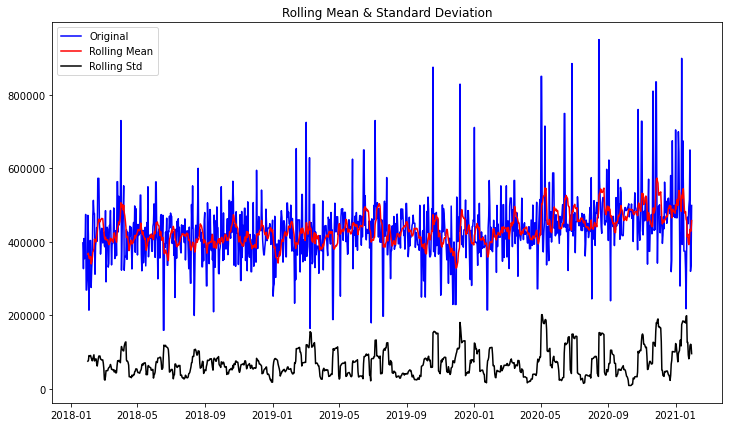

In [17]:
# make a new df with just the date and price
temp_df = df[['latest_saledate', 'latestPrice']]

# convert our date field to a proper datetime
temp_df['latest_saledate'] = pd.to_datetime(temp_df['latest_saledate'])

# drop outliers (somewhat arbitrary)
temp_df.drop(temp_df.loc[(temp_df['latestPrice'] > 1000000) | (temp_df['latestPrice'] < 100000)].index, axis=0, inplace=True)

# set the date as our index
temp_df.set_index('latest_saledate', inplace=True)

# group our data by day
temp = temp_df.groupby(pd.Grouper(freq='D')).mean()

# backfill any empty days by getting previous day's mean
temp.bfill(inplace=True)

# find the rolling mean and rolling standard deviation
roll_mean = temp.rolling(window=10, center=False).mean()
roll_std = temp.rolling(window=10, center=False).std()

# plot the figure with rolling mean and standard deviation
fig = plt.figure(figsize=(12,7))
plt.plot(temp, color='blue', label='Original')
plt.plot(roll_mean, color='red', label='Rolling Mean')
plt.plot(roll_std, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

We run a Dickey-Fuller hypothesis test on our time series to test for stationarity. The null hypothesis is that the data is not stationary. If we have a p-value below .05, we will reject the null hypothesis.

In [18]:
dftest = adfuller(temp)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                -8.327194e+00
p-value                        3.445082e-13
#Lags Used                     8.000000e+00
Number of Observations Used    1.096000e+03
Critical Value (1%)           -3.436331e+00
Critical Value (5%)           -2.864181e+00
Critical Value (10%)          -2.568176e+00
dtype: float64


The p-value of 3.45e-13 on the Dickey-Fuller test is FAR under .05, so we reject the null hypothesis that there is a trend in the data. Our data set is not exhibiting time series trends, so we don't need to account for this (surprisingly!!)

In [19]:
# on our original df, convert the date to a proper date-time, and then drop the day so it's only year-month
df['latest_saledate'] = pd.to_datetime(df['latest_saledate'])
df['latest_saledate'] = df['latest_saledate'].dt.strftime('%Y-%m')

In [20]:
df.rename(columns={'latestPrice':'price', 'latest_saledate':'sale_date'}, inplace=True)

In [21]:
df.drop(['latest_salemonth', 'latest_saleyear'], axis=1, inplace=True)

### Checking homeType

In [22]:
# what are the homeTypes?

df['homeType'].value_counts(normalize=True)

Single Family            0.938699
Condo                    0.030980
Townhouse                0.011469
Multiple Occupancy       0.006328
Vacant Land              0.005471
Residential              0.002439
Apartment                0.002439
Mobile / Manufactured    0.001121
MultiFamily              0.000659
Other                    0.000395
Name: homeType, dtype: float64

In [23]:
# Ultimately, with Single Family, Condo and Townhouse making up most of the data, we are going to remove all multi-family type listings
df = df.loc[((df['homeType'] == 'Single Family') | (df['homeType'] == 'Condo')) | (df['homeType'] == 'Townhouse')]

### Duplicate Data

In [24]:
# check for duplicate data

df[df.duplicated(subset=['latitude','longitude'], keep=False)].sort_values('latitude')

# no duplicate data

,zpid,city,streetAddress,zipcode,description,latitude,longitude,propertyTaxRate,garageSpaces,hasAssociation,hasCooling,hasGarage,hasHeating,hasSpa,hasView,homeType,parkingSpaces,yearBuilt,price,numPriceChanges,sale_date,latestPriceSource,numOfPhotos,numOfAccessibilityFeatures,numOfAppliances,numOfParkingFeatures,numOfPatioAndPorchFeatures,numOfSecurityFeatures,numOfWaterfrontFeatures,numOfWindowFeatures,numOfCommunityFeatures,lotSizeSqFt,livingAreaSqFt,numOfPrimarySchools,numOfElementarySchools,numOfMiddleSchools,numOfHighSchools,avgSchoolDistance,avgSchoolRating,avgSchoolSize,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories,homeImage


### Outlier Detection

In [25]:
'''# plotting latitude and longitude as a visual scatter plot to look for location-based outliers

plt.figure(figsize=(25,25))

sns.scatterplot(data=df, x="longitude", y="latitude", hue="price", palette="magma_r");'''

'# plotting latitude and longitude as a visual scatter plot to look for location-based outliers\n\nplt.figure(figsize=(25,25))\n\nsns.scatterplot(data=df, x="longitude", y="latitude", hue="price", palette="magma_r");'

Using latitude and longitude, we make a visual map of the Austin area that lets us see any map outliers. There don't appear to be any zones that are well outside of the Austin area, except for just a few down in the lower SE area. So we might plan to cut off our latitude just above 30.1.

This visualization suggests that location is very important to home price. We'll check that out more directly.

In [26]:
# drop latitidue below 30.12 to remove the few outliers in the SE
df.drop(df[df['latitude']<30.12].index , inplace=True)

In [27]:
# looking for outliers in the percentiles

df.describe()

,zpid,zipcode,latitude,longitude,propertyTaxRate,garageSpaces,parkingSpaces,yearBuilt,price,numPriceChanges,numOfPhotos,numOfAccessibilityFeatures,numOfAppliances,numOfParkingFeatures,numOfPatioAndPorchFeatures,numOfSecurityFeatures,numOfWaterfrontFeatures,numOfWindowFeatures,numOfCommunityFeatures,lotSizeSqFt,livingAreaSqFt,numOfPrimarySchools,numOfElementarySchools,numOfMiddleSchools,numOfHighSchools,avgSchoolDistance,avgSchoolRating,avgSchoolSize,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories
count,1.488000e+04,14880.000000,14880.000000,14880.000000,14880.000000,14880.000000,14880.000000,14880.000000,1.488000e+04,14880.000000,14880.000000,14880.000000,14880.000000,14880.000000,14880.000000,14880.000000,14880.000000,14880.000000,14880.000000,1.488000e+04,14880.000000,14880.000000,14880.000000,14880.000000,14880.000000,14880.000000,14880.000000,14880.000000,14880.000000,14880.000000,14880.000000,14880.000000
mean,1.043332e+08,78736.001075,30.291923,-97.778870,1.994194,1.228159,1.227554,1988.720228,5.119011e+05,3.032997,30.830645,0.013239,3.490927,1.710081,0.667608,0.472446,0.002621,0.210753,0.011761,1.207274e+05,2205.497177,0.941062,0.048790,1.034946,0.977621,1.838871,5.792622,1240.125134,14.868952,2.696704,3.441599,1.469422
std,3.171262e+08,18.879984,0.097245,0.084904,0.053290,1.342097,1.342224,21.504783,4.413982e+05,2.481883,21.187673,0.181175,1.868605,0.778832,0.983225,0.828483,0.059625,0.490729,0.113874,1.237193e+07,1368.133002,0.235802,0.234267,0.260259,0.292564,1.065639,1.859791,325.654819,1.743026,1.025875,0.811953,0.523915
min,2.858495e+07,78617.000000,30.127161,-98.022057,1.980000,0.000000,0.000000,1905.000000,5.500000e+03,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+02,300.000000,0.000000,0.000000,0.000000,0.000000,0.200000,2.333333,396.000000,10.000000,0.000000,0.000000,1.000000
25%,2.941134e+07,78727.000000,30.202993,-97.838747,1.980000,0.000000,0.000000,1975.000000,3.090000e+05,1.000000,20.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.534000e+03,1485.000000,1.000000,0.000000,1.000000,1.000000,1.100000,4.000000,983.000000,14.000000,2.000000,3.000000,1.000000
50%,2.949518e+07,78739.000000,30.285250,-97.769810,1.980000,1.000000,1.000000,1993.000000,4.050000e+05,2.000000,29.000000,0.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.232000e+03,1976.000000,1.000000,0.000000,1.000000,1.000000,1.566667,6.000000,1298.000000,15.000000,3.000000,3.000000,1.000000
75%,7.033871e+07,78749.000000,30.367340,-97.718283,1.980000,2.000000,2.000000,2006.000000,5.750000e+05,4.000000,39.000000,0.000000,4.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.089000e+04,2687.000000,1.000000,0.000000,1.000000,1.000000,2.266667,7.000000,1498.500000,16.000000,3.000000,4.000000,2.000000
max,2.146313e+09,78759.000000,30.517174,-97.569504,2.210000,22.000000,22.000000,2020.000000,1.350000e+07,23.000000,179.000000,8.000000,10.000000,6.000000,8.000000,6.000000,2.000000,4.000000,3.000000,1.508483e+09,109292.000000,2.000000,2.000000,3.000000,2.000000,9.000000,9.500000,1913.000000,19.000000,27.000000,20.000000,4.000000


We see potential outliers in price, lotSizeSqFt, livingAreaSqFt, and numOfBathrooms, numOfBedrooms, garageSpaces, parkingSpaces.

In [28]:
'''# check how our histograms are looking
df.hist(figsize=(18,15), bins=100);
'''

'# check how our histograms are looking\ndf.hist(figsize=(18,15), bins=100);\n'

In [29]:
#check what is going on with the lotSizeSqFt outliers by sorting descending
df.sort_values('lotSizeSqFt', ascending=False).head(5)

# This top listing is legitimate. But we have a problem here where condo and townhouse listings are using the 
# size of the overall lot for their lot, and that isn't really accurate/representative
# We'll fix this in a little bit

,zpid,city,streetAddress,zipcode,description,latitude,longitude,propertyTaxRate,garageSpaces,hasAssociation,hasCooling,hasGarage,hasHeating,hasSpa,hasView,homeType,parkingSpaces,yearBuilt,price,numPriceChanges,sale_date,latestPriceSource,numOfPhotos,numOfAccessibilityFeatures,numOfAppliances,numOfParkingFeatures,numOfPatioAndPorchFeatures,numOfSecurityFeatures,numOfWaterfrontFeatures,numOfWindowFeatures,numOfCommunityFeatures,lotSizeSqFt,livingAreaSqFt,numOfPrimarySchools,numOfElementarySchools,numOfMiddleSchools,numOfHighSchools,avgSchoolDistance,avgSchoolRating,avgSchoolSize,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories,homeImage
14654,58297775,austin,3200 W 35th St,78703,Fabulous 4 Bed 4 Bath house on one of the larg...,30.314316,-97.768044,1.98,5,False,True,True,True,False,False,Single Family,5,1955,1650000.0,3,2020-02,Broker Provided,23,0,8,2,2,1,0,0,0,1.508483e+09,3328.0,1,0,1,1,1.633333,7.000000,1298,16,4.0,4,2,58297775_ea7a00b4cbb5788f252f04fce1c9e84a-p_f.jpg
9244,62605548,austin,706 W 22nd St APT 306,78705,Leased for $1695 though 7/31/2020 - Unique gat...,30.285631,-97.745697,1.98,0,True,True,False,True,False,False,Condo,0,1982,179900.0,7,2019-10,Agent Provided,16,0,4,0,0,0,0,0,0,3.415452e+07,728.0,1,0,1,1,1.533333,6.000000,1196,16,1.0,2,1,62605548_0b3873e5b78f01227ad3a038c06a6f13-p_f.jpg
11116,145652991,austin,4319 Nitschke St,78723,**Subject to City of Austin SMART Housing and ...,30.294910,-97.698997,1.98,1,True,True,True,True,False,False,Townhouse,1,2016,187471.0,1,2020-06,Agent Provided,26,0,3,2,0,1,0,1,0,2.617956e+07,815.0,1,0,1,1,2.166667,5.000000,966,15,2.0,2,2,145652991_0b5dacd57ed4126cdfdd8d563bb0c043-p_f...
2340,124837778,austin,4304 Front Range Ln,78732,"4304 Front Range Ln, Austin, TX 78732 is a sin...",30.380476,-97.881027,1.98,2,True,True,True,True,False,True,Single Family,2,2014,569000.0,1,2019-03,Agent Provided,33,0,4,2,0,0,0,0,0,8.712000e+06,3183.0,1,0,1,1,1.833333,8.333333,1476,17,3.0,4,2,124837778_99ba1046c98f724f8866c5cdc5afe169-p_f...
4635,202157510,austin,201 Charismatic Pl,78737,"201 Charismatic Pl, Austin, TX 78737 is a sing...",30.205276,-98.011406,2.01,3,True,True,True,True,True,False,Single Family,3,2015,999500.0,3,2019-11,Broker Provided,1,0,4,2,0,0,0,0,0,8.581320e+06,4459.0,1,0,1,1,5.533333,6.666667,1132,16,6.0,5,2,202157510_b30ae95a57301eb1d73cb91350beef3a-p_f...


In [30]:
#check what is going on with the livingAreaSqFt outliers by sorting ascending
df.sort_values('livingAreaSqFt', ascending=True).head(5)

# just tiny houses I guess ?

,zpid,city,streetAddress,zipcode,description,latitude,longitude,propertyTaxRate,garageSpaces,hasAssociation,hasCooling,hasGarage,hasHeating,hasSpa,hasView,homeType,parkingSpaces,yearBuilt,price,numPriceChanges,sale_date,latestPriceSource,numOfPhotos,numOfAccessibilityFeatures,numOfAppliances,numOfParkingFeatures,numOfPatioAndPorchFeatures,numOfSecurityFeatures,numOfWaterfrontFeatures,numOfWindowFeatures,numOfCommunityFeatures,lotSizeSqFt,livingAreaSqFt,numOfPrimarySchools,numOfElementarySchools,numOfMiddleSchools,numOfHighSchools,avgSchoolDistance,avgSchoolRating,avgSchoolSize,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories,homeImage
1170,94641643,austin,3003 Brass Buttons Trl,78734,Lake Austin Waterfront lot in Apache Shores! O...,30.381195,-97.915985,1.98,0,True,True,False,True,False,False,Single Family,0,2012,850000.0,4,2018-07,Agent Provided,49,0,1,0,0,0,0,0,0,23522.4,300.0,1,0,1,1,2.633333,7.000000,1715,16,2.0,2,1,94641643_9764275995e6a1d64eb9ee3383342db7-p_f.jpg
3518,29420819,austin,404 Primrose St,78753,"404 Primrose St, Austin, TX 78753 is a single ...",30.350330,-97.697739,1.98,0,False,False,False,False,False,False,Single Family,0,1945,139000.0,1,2019-07,Broker Provided,1,0,0,0,0,0,0,0,0,11761.2,306.0,1,0,1,1,0.933333,2.666667,932,14,1.0,1,1,29420819_eacd95953733cf1630001311c5c3d8dd-p_f.jpg
13314,29330022,austin,1405 Hartford Rd APT 202,78703,Old West Austin Efficiency. Close to metro/UT ...,30.284014,-97.762421,1.98,0,True,True,False,True,False,False,Condo,0,1972,175000.0,1,2019-10,Agent Provided,16,0,3,0,1,1,0,1,0,657.0,378.0,1,0,1,1,0.600000,6.000000,1189,16,1.0,0,1,29330022_325baca18f3fe6664c210987fd58ed8a-p_f.jpg
10118,29385318,austin,2202 E 10th St,78702,Great opportunity to build on your lot in high...,30.264668,-97.717590,1.98,2,True,True,True,True,False,True,Condo,2,2019,499000.0,4,2019-10,Broker Provided,29,0,3,2,0,1,0,0,0,5837.0,450.0,1,0,1,1,1.033333,5.000000,697,11,1.0,1,2,29385318_8cb1b5c135c1df01c788a481e928d68c-p_f.jpg
9213,145658912,austin,1011 W 23rd St APT 103,78705,Very desirable location for UT students only 5...,30.287077,-97.748085,1.98,1,True,True,True,True,False,True,Condo,1,1972,151500.0,5,2018-09,Agent Provided,1,0,5,2,0,0,0,0,0,815.0,450.0,1,0,1,1,1.400000,6.000000,1196,16,1.0,1,1,145658912_71f342a92115aa75aac958c41f6e7543-p_f...


In [31]:
#check what is going on with the livingAreaSqFt outliers by sorting descending
df.sort_values('livingAreaSqFt', ascending=False).head(5)

,zpid,city,streetAddress,zipcode,description,latitude,longitude,propertyTaxRate,garageSpaces,hasAssociation,hasCooling,hasGarage,hasHeating,hasSpa,hasView,homeType,parkingSpaces,yearBuilt,price,numPriceChanges,sale_date,latestPriceSource,numOfPhotos,numOfAccessibilityFeatures,numOfAppliances,numOfParkingFeatures,numOfPatioAndPorchFeatures,numOfSecurityFeatures,numOfWaterfrontFeatures,numOfWindowFeatures,numOfCommunityFeatures,lotSizeSqFt,livingAreaSqFt,numOfPrimarySchools,numOfElementarySchools,numOfMiddleSchools,numOfHighSchools,avgSchoolDistance,avgSchoolRating,avgSchoolSize,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories,homeImage
705,70330356,austin,201 Marly Way,78733,Level building site with great canyon views an...,30.323517,-97.861473,1.98,0,True,True,False,True,False,False,Single Family,0,2012,385000.0,2,2018-11,Agent Provided,1,0,0,1,0,0,0,0,0,109335.6,109292.0,0,1,3,0,3.233333,8.000000,1373,14,0.0,5,2,70330356_streetviewsize1025x768location30.3235...
2557,64523076,austin,9704 Saugus Ln,78733,"New Construction, EANES Schools, 4bed 3 bath, ...",30.345898,-97.859985,1.98,0,True,True,False,True,False,False,Single Family,0,2018,829000.0,1,2018-03,Agent Provided,1,0,1,1,0,0,0,0,0,103237.2,29440.0,0,1,3,0,4.300000,8.000000,1373,14,0.0,1,2,64523076_streetviewlocation9704SaugusLn2CAusti...
2316,125904370,austin,12400 Cedar St,78732,12400 Cedar Street - Villa Del Lago is a uniqu...,30.392859,-97.877609,1.98,5,False,True,True,True,False,True,Single Family,5,2016,13500000.0,2,2018-11,Agent Provided,13,0,0,2,0,0,0,0,0,710899.2,15394.0,1,0,1,1,2.200000,8.333333,1476,17,13.0,6,1,125904370_a200adec53a31c17278601026747d1ae-p_f...
5328,29327226,austin,3509 Lost Creek Blvd,78735,"*$6,762,377 is Tax Value - Set in exclusive Ba...",30.272158,-97.856033,1.98,7,True,True,True,True,True,False,Single Family,7,2003,2700000.0,4,2018-05,Agent Provided,39,0,5,3,0,0,0,0,0,138956.4,14091.0,1,0,1,1,4.300000,5.666667,1332,16,10.0,6,3,29327226_811cfb134911b60830174fb4700afc39-p_f.jpg
375,89551873,austin,14800 Flat Top Ranch Rd,78732,GRACIOUS LUXURY ON LAKE AUSTIN\r\nThis award-w...,30.368996,-97.912720,1.98,6,True,True,True,True,True,True,Single Family,6,2014,4950000.0,6,2018-08,Agent Provided,34,0,3,2,0,0,0,0,0,116740.8,13731.0,1,0,1,1,2.733333,8.333333,1476,17,10.0,5,2,89551873_acca4b6361693761e8631145233ffd75-p_f.jpg


In [32]:
# we're dropping the top two listings here. One is a lot, and the other is clearly mistaken.
df.drop(index=[705, 2557], inplace=True)

In [33]:
#check what is going on with the numOfBathrooms outliers by sorting descending
df.sort_values('numOfBathrooms', ascending=False).head(5)

,zpid,city,streetAddress,zipcode,description,latitude,longitude,propertyTaxRate,garageSpaces,hasAssociation,hasCooling,hasGarage,hasHeating,hasSpa,hasView,homeType,parkingSpaces,yearBuilt,price,numPriceChanges,sale_date,latestPriceSource,numOfPhotos,numOfAccessibilityFeatures,numOfAppliances,numOfParkingFeatures,numOfPatioAndPorchFeatures,numOfSecurityFeatures,numOfWaterfrontFeatures,numOfWindowFeatures,numOfCommunityFeatures,lotSizeSqFt,livingAreaSqFt,numOfPrimarySchools,numOfElementarySchools,numOfMiddleSchools,numOfHighSchools,avgSchoolDistance,avgSchoolRating,avgSchoolSize,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories,homeImage
2838,111972888,austin,4212 Far West Blvd,78731,Well-maintained home in highly desirable North...,30.361406,-97.769707,1.98,2,False,True,True,True,False,False,Single Family,2,1967,745000.0,1,2020-10,Agent Provided,46,0,4,2,0,0,0,0,0,10236.0,2137.0,1,0,1,1,0.933333,7.000000,1483,16,27.0,4,1,111972888_a88e572d95e496b1b5d9a591800497c4-p_f...
2316,125904370,austin,12400 Cedar St,78732,12400 Cedar Street - Villa Del Lago is a uniqu...,30.392859,-97.877609,1.98,5,False,True,True,True,False,True,Single Family,5,2016,13500000.0,2,2018-11,Agent Provided,13,0,0,2,0,0,0,0,0,710899.2,15394.0,1,0,1,1,2.200000,8.333333,1476,17,13.0,6,1,125904370_a200adec53a31c17278601026747d1ae-p_f...
184,124843021,austin,13115 Perryton Dr,78732,This highly custom home sits on a well-establi...,30.338959,-97.926979,1.98,4,True,True,True,True,True,True,Single Family,4,2014,4100000.0,3,2020-12,Broker Provided,149,0,8,3,0,0,0,0,0,172497.6,9866.0,1,0,1,1,3.433333,8.333333,1533,17,10.0,6,2,124843021_38aeda802d6cf001f7befec5a053d009-p_f...
5328,29327226,austin,3509 Lost Creek Blvd,78735,"*$6,762,377 is Tax Value - Set in exclusive Ba...",30.272158,-97.856033,1.98,7,True,True,True,True,True,False,Single Family,7,2003,2700000.0,4,2018-05,Agent Provided,39,0,5,3,0,0,0,0,0,138956.4,14091.0,1,0,1,1,4.300000,5.666667,1332,16,10.0,6,3,29327226_811cfb134911b60830174fb4700afc39-p_f.jpg
375,89551873,austin,14800 Flat Top Ranch Rd,78732,GRACIOUS LUXURY ON LAKE AUSTIN\r\nThis award-w...,30.368996,-97.912720,1.98,6,True,True,True,True,True,True,Single Family,6,2014,4950000.0,6,2018-08,Agent Provided,34,0,3,2,0,0,0,0,0,116740.8,13731.0,1,0,1,1,2.733333,8.333333,1476,17,10.0,5,2,89551873_acca4b6361693761e8631145233ffd75-p_f.jpg


In [34]:
# I'm going to say this top listing has 2.5 bathrooms not 27. That is clearly a typo.
df.loc[df.index==2838, 'numOfBathrooms'] = 2.5

In [35]:
#check what is going on with the numOfBathrooms outliers by sorting ascending
df.sort_values('numOfBathrooms', ascending=True).head(5)

,zpid,city,streetAddress,zipcode,description,latitude,longitude,propertyTaxRate,garageSpaces,hasAssociation,hasCooling,hasGarage,hasHeating,hasSpa,hasView,homeType,parkingSpaces,yearBuilt,price,numPriceChanges,sale_date,latestPriceSource,numOfPhotos,numOfAccessibilityFeatures,numOfAppliances,numOfParkingFeatures,numOfPatioAndPorchFeatures,numOfSecurityFeatures,numOfWaterfrontFeatures,numOfWindowFeatures,numOfCommunityFeatures,lotSizeSqFt,livingAreaSqFt,numOfPrimarySchools,numOfElementarySchools,numOfMiddleSchools,numOfHighSchools,avgSchoolDistance,avgSchoolRating,avgSchoolSize,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories,homeImage
6252,29327134,austin,2005 Real Catorce,78746,"2005 Real Catorce, Austin, TX 78746 is a singl...",30.269354,-97.818771,1.98,0,True,True,False,True,False,False,Single Family,0,1999,949000.0,4,2018-10,Agent Provided,1,0,4,1,0,0,0,0,0,14810.4,5187.0,0,1,1,0,0.600000,9.500000,1630,14,0.0,5,2,29327134_streetviewsize1025x768location30.2693...
6646,29503854,austin,8604 Oak Ledge Dr,78748,"8604 Oak Ledge Dr, Austin, TX 78748 is a singl...",30.188589,-97.823662,1.98,0,False,True,False,True,False,False,Single Family,0,1971,450000.0,1,2019-08,Broker Provided,1,0,4,2,2,0,0,2,0,17424.0,1660.0,1,0,1,1,2.266667,5.666667,1537,16,0.0,0,1,29503854_streetviewlocation8604OakLedgeDr2CAus...
1842,94642666,austin,10640 Senna Hills Dr,78733,Wow! Reduced! First time on the market! Move i...,30.312716,-97.900482,1.98,2,True,True,True,True,False,True,Single Family,2,2011,895000.0,5,2020-06,Agent Provided,35,0,3,2,0,0,0,0,0,12196.8,3809.0,0,1,3,0,2.766667,9.333333,1360,14,0.0,0,2,94642666_5d6e752fd9e13c6e7241c68017dd5319-p_f.jpg
2223,58299964,austin,5138 Mansfield View Ct,78732,"5138 Mansfield View Ct, Austin, TX 78732 is a ...",30.390335,-97.882072,1.98,2,True,True,True,True,False,True,Single Family,2,2000,850000.0,9,2020-05,,6,0,3,3,1,2,0,2,0,17424.0,3423.0,1,0,1,1,2.100000,8.333333,1476,17,0.0,4,2,58299964_747f1d8b4915b675bca16aff4f6bcc2d-p_f.jpg
12993,58315415,austin,4712 Chesney Ridge Dr,78749,"This Austin two-story offers a fireplace, an o...",30.197540,-97.862419,1.98,2,True,True,True,True,False,False,Single Family,2,2000,447000.0,12,2019-10,Broker Provided,1,0,4,2,1,1,0,0,0,7187.0,3271.0,1,0,1,1,1.600000,7.333333,1576,16,0.0,5,2,58315415_streetviewlocation4712ChesneyRidgeDr2...


In [36]:
# most listings with 0 bathrooms also have 0 bedrooms. This is clearly wrong, but I'm not going to guess if there are no bedrooms.
# I will impute typical bathroom count per bedroom count based on year built
# then drop any remaining listings with 0 bathrooms and 0 bedrooms

df.loc[(df['numOfBathrooms']==0) & (df['numOfBedrooms']>0) & (df['yearBuilt'] > 1989), 'numOfBathrooms'] = 2
df.loc[(df['numOfBathrooms']==0) & (df['numOfBedrooms']>0) & (df['yearBuilt'] <= 1989), 'numOfBathrooms'] = 1
df.loc[(df['numOfBathrooms']==0) & (df['numOfBedrooms']>=3) & (df['yearBuilt'] > 1989), 'numOfBathrooms'] = 2.5
df.loc[(df['numOfBathrooms']==0) & (df['numOfBedrooms']>=3) & (df['yearBuilt'] <= 1989), 'numOfBathrooms'] = 2

df.drop(df[df['numOfBathrooms']==0].index, inplace=True)
df.drop(df[df['numOfBedrooms']==0].index, inplace=True)

In [37]:
#check what is going on with the numOfBedrooms outliers by sorting descending
df.sort_values('numOfBedrooms', ascending=False).head(5)

,zpid,city,streetAddress,zipcode,description,latitude,longitude,propertyTaxRate,garageSpaces,hasAssociation,hasCooling,hasGarage,hasHeating,hasSpa,hasView,homeType,parkingSpaces,yearBuilt,price,numPriceChanges,sale_date,latestPriceSource,numOfPhotos,numOfAccessibilityFeatures,numOfAppliances,numOfParkingFeatures,numOfPatioAndPorchFeatures,numOfSecurityFeatures,numOfWaterfrontFeatures,numOfWindowFeatures,numOfCommunityFeatures,lotSizeSqFt,livingAreaSqFt,numOfPrimarySchools,numOfElementarySchools,numOfMiddleSchools,numOfHighSchools,avgSchoolDistance,avgSchoolRating,avgSchoolSize,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories,homeImage
8597,2094498207,austin,4902 Duval Rd R2 #R2,78727,"Lovely convenient condo, with a private wooded...",30.415489,-97.737213,1.98,0,True,True,False,True,False,True,Condo,0,1985,174900.0,2,2020-11,Agent Provided,25,0,4,1,0,0,0,0,0,5227.0,916.0,1,0,1,1,2.400000,6.000000,1474,15,2.0,20,1,2094498207_76320ecfd86161cc1d91c46c95c1afcf-p_...
8531,58306332,austin,3906 Hawkshead Dr,78727,Enjoy this home across from The Domain! Comple...,30.416149,-97.722801,1.98,2,False,True,True,True,False,False,Single Family,2,2006,650000.0,1,2020-08,Agent Provided,36,0,2,2,2,3,0,1,0,9191.0,4712.0,1,0,1,1,2.666667,6.666667,1486,15,4.0,8,2,58306332_c0963729ec7bd42164615c02d9825a50-p_f.jpg
14435,29401385,austin,4302 Avenue G APT C,78751,Charming 3-unit multifamily property built by ...,30.305981,-97.728012,1.98,0,False,False,False,True,False,False,Single Family,0,1925,750000.0,1,2018-04,Agent Provided,15,0,0,1,0,0,0,0,0,5662.0,2340.0,1,0,1,1,1.433333,7.333333,1142,15,4.0,7,2,29401385_19535e7778c048c5b703ef78b6b40c77-p_f.jpg
13910,29322655,austin,1608 S 2nd St,78704,Modern luxury by Joseph Design Build with prim...,30.249325,-97.757095,1.98,5,False,True,True,True,False,False,Single Family,5,2020,3450000.0,4,2020-04,Agent Provided,37,0,4,3,0,0,0,0,0,12632.4,4956.0,1,0,1,1,0.666667,5.000000,889,13,7.0,7,2,29322655_46672f649e50f848a746a7b0421c2ed2-p_f.jpg
9314,29384319,austin,1310 E 2nd St,78702,"Contact owner for showing, day before advance ...",30.260422,-97.730194,1.98,2,False,True,True,True,False,True,Single Family,2,1915,599995.0,7,2020-03,Agent Provided,1,0,3,3,0,0,0,0,0,6577.0,2403.0,1,0,1,1,1.100000,4.666667,992,14,7.0,7,2,29384319_8c7c32099fdfd1895eb36b68cbad62c9-p_f.jpg


In [38]:
# That condo is supposed to have 2 bathrooms, not 20.
df.loc[df.index==8597, 'numOfBedrooms'] = 2

In [39]:
#check what is going on with the garageSpaces outliers by sorting descending
df.sort_values('garageSpaces', ascending=False).head(10)

,zpid,city,streetAddress,zipcode,description,latitude,longitude,propertyTaxRate,garageSpaces,hasAssociation,hasCooling,hasGarage,hasHeating,hasSpa,hasView,homeType,parkingSpaces,yearBuilt,price,numPriceChanges,sale_date,latestPriceSource,numOfPhotos,numOfAccessibilityFeatures,numOfAppliances,numOfParkingFeatures,numOfPatioAndPorchFeatures,numOfSecurityFeatures,numOfWaterfrontFeatures,numOfWindowFeatures,numOfCommunityFeatures,lotSizeSqFt,livingAreaSqFt,numOfPrimarySchools,numOfElementarySchools,numOfMiddleSchools,numOfHighSchools,avgSchoolDistance,avgSchoolRating,avgSchoolSize,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories,homeImage
6885,145656156,austin,705 Mc Queen St #34,78745,Beautiful 2-story home located in highly sough...,30.189331,-97.792809,1.98,22,True,True,True,True,False,True,Condo,22,2016,399000.0,1,2020-11,Agent Provided,30,0,2,2,3,0,0,0,0,6621.0,2080.0,1,0,1,1,0.866667,3.333333,926,13,3.0,4,1,145656156_7eaa8fc35c2a80099dae663115c8e34a-p_f...
4533,28587235,austin,13100 Rooster Springs Rd,78737,Enjoy country living with the convenience of t...,30.204746,-97.991356,2.01,20,False,True,True,True,False,True,Single Family,20,2018,824900.0,2,2018-03,Agent Provided,3,0,7,3,0,0,0,0,0,337590.0,4004.0,1,0,1,1,6.766667,6.666667,1132,16,5.0,4,1,28587235_5a6a7b48074e944ed02a280f06dfaa43-p_f.jpg
4777,29331364,austin,3301 Barton Creek Blvd,78735,Privately gated Barton Creek estate on 1.58 Ac...,30.283585,-97.875526,1.98,12,True,True,True,True,True,False,Single Family,12,1991,1595000.0,15,2020-12,"Compass RE Texas, LLC",72,0,3,3,2,1,0,0,0,68824.8,5170.0,1,0,1,1,5.366667,5.666667,1332,16,5.0,4,2,29331364_70cdb457329d7f8822ea9907032f8716-p_f.jpg
9240,29396074,austin,908 Keith Ln,78705,Keith Lane is has our homes strategically plac...,30.291706,-97.725502,1.98,12,False,True,True,True,False,False,Single Family,12,2003,3400000.0,1,2020-04,Agent Provided,20,0,5,4,0,0,0,0,0,20908.8,3075.0,1,0,1,1,1.233333,7.333333,1142,15,3.0,6,2,29396074_b1521d52623a64343f61e3093ea83446-p_f.jpg
6805,29502805,austin,7600 Elm Forest Rd,78745,Gorgeous 3/2 home owner remodel on almost 2/3 ...,30.190971,-97.800804,1.98,12,False,True,True,True,False,False,Single Family,12,1960,525000.0,7,2019-08,Agent Provided,33,0,8,1,2,2,0,2,0,27007.2,1806.0,1,0,1,1,1.566667,3.333333,1409,14,2.0,3,1,29502805_59509f778dbf2a2d4ff966ffd89f01f6-p_f.jpg
6985,29494837,austin,6907 Cherrydale Dr,78745,Beautifully remodeled home in HOT 78745!! This...,30.200857,-97.803902,1.98,12,False,True,True,True,False,True,Single Family,12,1972,328000.0,3,2020-12,Agent Provided,46,0,4,2,1,0,0,0,0,7927.0,880.0,1,0,1,1,1.233333,4.000000,840,13,1.0,3,1,29494837_df65b7181d2b1d4749672b8b95f365b0-p_f.jpg
11108,29409917,austin,1405 Berkshire Dr,78723,Beautifully renovated single story mid-century...,30.317060,-97.697220,1.98,12,False,True,True,True,False,True,Single Family,12,1955,500000.0,2,2020-11,Agent Provided,29,0,3,2,2,0,0,0,0,7797.0,1209.0,1,0,1,1,0.700000,3.000000,849,14,2.0,3,1,29409917_884d8f325332b7b38909b77751e3b189-p_f.jpg
14875,29415933,austin,5804 Bullard Dr,78757,"5804 Bullard Dr, Austin, TX 78757 is a single ...",30.336634,-97.750031,1.98,10,False,True,True,True,False,True,Single Family,10,1958,450000.0,5,2019-06,Broker Provided,1,0,8,4,0,0,0,0,0,10018.0,2226.0,1,0,1,1,0.800000,6.666667,1153,16,2.0,3,1,29415933_c80565e4044d0ae688fb802478bf44a3-p_f.jpg
6230,29327172,austin,1814 Randolph Ridge Trl,78746,"Stunning home in Eanes, minutes from downtow...",30.272011,-97.821548,1.98,10,True,True,True,True,True,True,Single Family,10,1999,1850000.0,5,2018-09,Agent Provided,39,0,6,3,0,0,0,0,0,30056.4,5792.0,0,1,1,0,0.550000,9.500000,1630,14,5.0,5,2,29327172_651d5bacae22a9c8f693720e0047ac3f-p_f.jpg
3459,29423855,austin,8909 Georgian Dr,78753,Unique opportunity to own a large lot in an ar...,30.356129,-97.695686,1.98,10,False,True,True,True,True,False,Single Family,10,1949,525000.0,4,2020-12,Agent Provided,66,0,0,3,1,3,0,0,0,30492.0,1416.0,1,0,1,1,0.900000,2.666667,932,14,3.0

In [40]:
# a bunch of these garage spaces are definitely just bogus numbers. I'm going to force change a lot of them to numbers that make sense
df.loc[(df['garageSpaces'] > 3) & (df['price'] < 1000000) & (df['homeType'] == 'Single Family'), 'garageSpaces'] = 3
df.loc[(df['garageSpaces'] > 5) & (df['price'] > 1000000)& (df['homeType'] == 'Single Family'), 'garageSpaces'] = 4
df.loc[df.index==6885, 'garageSpaces'] = 2

In [41]:
#check what is going on with the parkingSpaces outliers by sorting descending
df.sort_values('parkingSpaces', ascending=False).head(5)

,zpid,city,streetAddress,zipcode,description,latitude,longitude,propertyTaxRate,garageSpaces,hasAssociation,hasCooling,hasGarage,hasHeating,hasSpa,hasView,homeType,parkingSpaces,yearBuilt,price,numPriceChanges,sale_date,latestPriceSource,numOfPhotos,numOfAccessibilityFeatures,numOfAppliances,numOfParkingFeatures,numOfPatioAndPorchFeatures,numOfSecurityFeatures,numOfWaterfrontFeatures,numOfWindowFeatures,numOfCommunityFeatures,lotSizeSqFt,livingAreaSqFt,numOfPrimarySchools,numOfElementarySchools,numOfMiddleSchools,numOfHighSchools,avgSchoolDistance,avgSchoolRating,avgSchoolSize,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories,homeImage
6885,145656156,austin,705 Mc Queen St #34,78745,Beautiful 2-story home located in highly sough...,30.189331,-97.792809,1.98,2,True,True,True,True,False,True,Condo,22,2016,399000.0,1,2020-11,Agent Provided,30,0,2,2,3,0,0,0,0,6621.0,2080.0,1,0,1,1,0.866667,3.333333,926,13,3.0,4,1,145656156_7eaa8fc35c2a80099dae663115c8e34a-p_f...
4533,28587235,austin,13100 Rooster Springs Rd,78737,Enjoy country living with the convenience of t...,30.204746,-97.991356,2.01,3,False,True,True,True,False,True,Single Family,20,2018,824900.0,2,2018-03,Agent Provided,3,0,7,3,0,0,0,0,0,337590.0,4004.0,1,0,1,1,6.766667,6.666667,1132,16,5.0,4,1,28587235_5a6a7b48074e944ed02a280f06dfaa43-p_f.jpg
6985,29494837,austin,6907 Cherrydale Dr,78745,Beautifully remodeled home in HOT 78745!! This...,30.200857,-97.803902,1.98,3,False,True,True,True,False,True,Single Family,12,1972,328000.0,3,2020-12,Agent Provided,46,0,4,2,1,0,0,0,0,7927.0,880.0,1,0,1,1,1.233333,4.000000,840,13,1.0,3,1,29494837_df65b7181d2b1d4749672b8b95f365b0-p_f.jpg
6805,29502805,austin,7600 Elm Forest Rd,78745,Gorgeous 3/2 home owner remodel on almost 2/3 ...,30.190971,-97.800804,1.98,3,False,True,True,True,False,False,Single Family,12,1960,525000.0,7,2019-08,Agent Provided,33,0,8,1,2,2,0,2,0,27007.2,1806.0,1,0,1,1,1.566667,3.333333,1409,14,2.0,3,1,29502805_59509f778dbf2a2d4ff966ffd89f01f6-p_f.jpg
11108,29409917,austin,1405 Berkshire Dr,78723,Beautifully renovated single story mid-century...,30.317060,-97.697220,1.98,3,False,True,True,True,False,True,Single Family,12,1955,500000.0,2,2020-11,Agent Provided,29,0,3,2,2,0,0,0,0,7797.0,1209.0,1,0,1,1,0.700000,3.000000,849,14,2.0,3,1,29409917_884d8f325332b7b38909b77751e3b189-p_f.jpg


In [42]:
# We are going to do the same forced conversions on parking spaces
df.loc[(df['parkingSpaces'] > 3) & (df['price'] < 1000000 & (df['homeType'] == 'Single Family')), 'parkingSpaces'] = 3
df.loc[(df['parkingSpaces'] > 5) & (df['price'] > 1000000& (df['homeType'] == 'Single Family')), 'parkingSpaces'] = 5
df.loc[df.index==6885, 'parkingSpaces'] = 2

df.sort_values('parkingSpaces', ascending=False).head(5)

,zpid,city,streetAddress,zipcode,description,latitude,longitude,propertyTaxRate,garageSpaces,hasAssociation,hasCooling,hasGarage,hasHeating,hasSpa,hasView,homeType,parkingSpaces,yearBuilt,price,numPriceChanges,sale_date,latestPriceSource,numOfPhotos,numOfAccessibilityFeatures,numOfAppliances,numOfParkingFeatures,numOfPatioAndPorchFeatures,numOfSecurityFeatures,numOfWaterfrontFeatures,numOfWindowFeatures,numOfCommunityFeatures,lotSizeSqFt,livingAreaSqFt,numOfPrimarySchools,numOfElementarySchools,numOfMiddleSchools,numOfHighSchools,avgSchoolDistance,avgSchoolRating,avgSchoolSize,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories,homeImage
6114,29326930,austin,1308 Brians Meadow Cv,78746,Award winning EANES ISD. Cedar Creek Elementar...,30.269625,-97.803162,1.98,4,False,True,True,True,False,True,Single Family,5,1995,1050000.0,1,2018-05,Agent Provided,52,0,7,3,0,0,0,0,0,13939.2,3372.0,0,1,1,0,0.500000,9.000000,1600,14,4.0,4,2,29326930_9506188a2c6051f61bcaea75903f604d-p_f.jpg
5605,29361586,austin,12712 Mcnelly Trl,78732,Home is in immaculate condition with loads of ...,30.381527,-97.891388,1.98,3,True,True,True,True,False,True,Single Family,5,1993,394700.0,3,2019-03,Broker Provided,1,0,4,2,0,0,0,0,0,8276.0,2200.0,1,0,1,1,2.000000,8.333333,1476,17,3.0,4,2,29361586_7c62fada59b1e7abb7beb9fecb77273b-p_f.jpg
7073,29488557,austin,6507 Krollton Dr,78745,Beautiful one story home in Cherry Creek. Two...,30.208628,-97.810165,1.98,3,False,True,True,True,True,False,Single Family,5,1973,298000.0,9,2020-12,Broker Provided,35,0,4,2,1,2,0,0,0,6403.0,1342.0,1,0,1,1,0.900000,4.000000,840,13,2.0,3,1,29488557_537a82c1e5f460520c56e5c3d95e423c-p_f.jpg
4987,70332724,austin,10901 Strand St,78748,South Austin Gem! This beautifully updated 4 b...,30.167471,-97.843445,1.98,3,True,True,True,True,False,False,Single Family,5,2006,253500.0,4,2019-05,Agent Provided,32,0,7,4,0,1,0,1,0,9888.0,2388.0,1,0,1,1,1.833333,5.000000,1450,15,2.0,4,1,70332724_4780625f504619e0b31f7edbe40495f4-p_f.jpg
3558,29425216,austin,8519 Parkfield Dr,78758,Soak up the sunshine in this remodeled 3BR/4BA...,30.358917,-97.711327,1.98,3,False,True,True,True,True,False,Single Family,5,1965,289000.0,4,2019-03,Agent Provided,24,0,8,3,0,0,0,0,0,9331.0,2326.0,1,0,1,1,0.533333,4.000000,1028,14,4.0,4,2,29425216_933115fdc6dd2d36480a59bf04a286fc-p_f.jpg


In [43]:
'''# check how our histograms are looking for our columns that seem to have outliers

df.hist(figsize=(18,15), bins=100);'''

'# check how our histograms are looking for our columns that seem to have outliers\n\ndf.hist(figsize=(18,15), bins=100);'

For the square footage variables, I ultimately concluded that extremely large houses and lots are so seriously under-represented in the dataset that we won't be able to reliably predict on them anyway and they are better left off.

Ultimately I opt to remove via IQR on these items. 

In order to prevent a lot of data loss in this way, I kept IQR range of 1.6 instead of the standard 1.5

In [44]:
# determing our IQR for price, lot size, sq footage and longitude
lotlower,lotupper = iqr_outliers(df.lotSizeSqFt, 1.6)
sqftlower, sqftupper = iqr_outliers(df.livingAreaSqFt, 1.6)

# dropping the things outside of our lower and upper range
df.drop(df[ (df.lotSizeSqFt > lotupper) | (df.lotSizeSqFt < lotlower) ].index , inplace=True)
df.drop(df[ (df.livingAreaSqFt > sqftupper) | (df.livingAreaSqFt < sqftlower) ].index , inplace=True)

In [45]:
# We'll imputing the median lot size into condo and townhouse listings that are over-listed for lot size square feet

df.loc[(df['homeType']=='Condo') | (df['homeType']=='Townhouse') & (df['livingAreaSqFt']<1200) & (df['lotSizeSqFt']>8000), 'lotSizeSqFt'] = df['lotSizeSqFt'].median()

In [46]:
'''# check how our histograms are looking

df.hist(figsize=(18,20), bins=100);

# much better'''

'# check how our histograms are looking\n\ndf.hist(figsize=(18,20), bins=100);\n\n# much better'

##### Manually locating price outliers

In [47]:
# we're using the median house value for a zip code to determine the zip code's sort, so we can visualize the zip code

# group our dataframe by zipcode on median home price, sorted ascending. 
zipsorted = pd.DataFrame(df.groupby('zipcode')['price'].median().sort_values(ascending=True))

# divide our dataframe into groups with entries per group as specified above,
# and assign this number to a new column
zipsorted['rank'] = np.divmod(np.arange(len(zipsorted)), 1)[0]+1

# function that looks up a segment that a data entry belongs to
def make_group(x, frame, column):
    y = frame.loc[(frame.index == x)][column]
    z = np.array(y)
    z[0]
    return z[0]

# make a new column on our dataframe. Look up each zip entry's group, and append to the column.
df['zip_rank'] = df['zipcode'].apply(lambda x: make_group(x, zipsorted, 'rank'))

# apply the median home price per zip code to the data frame
df['median_zip'] = df['zipcode'].apply(lambda x: round(df.loc[df['zipcode']==x]['price'].median(), 0))

''

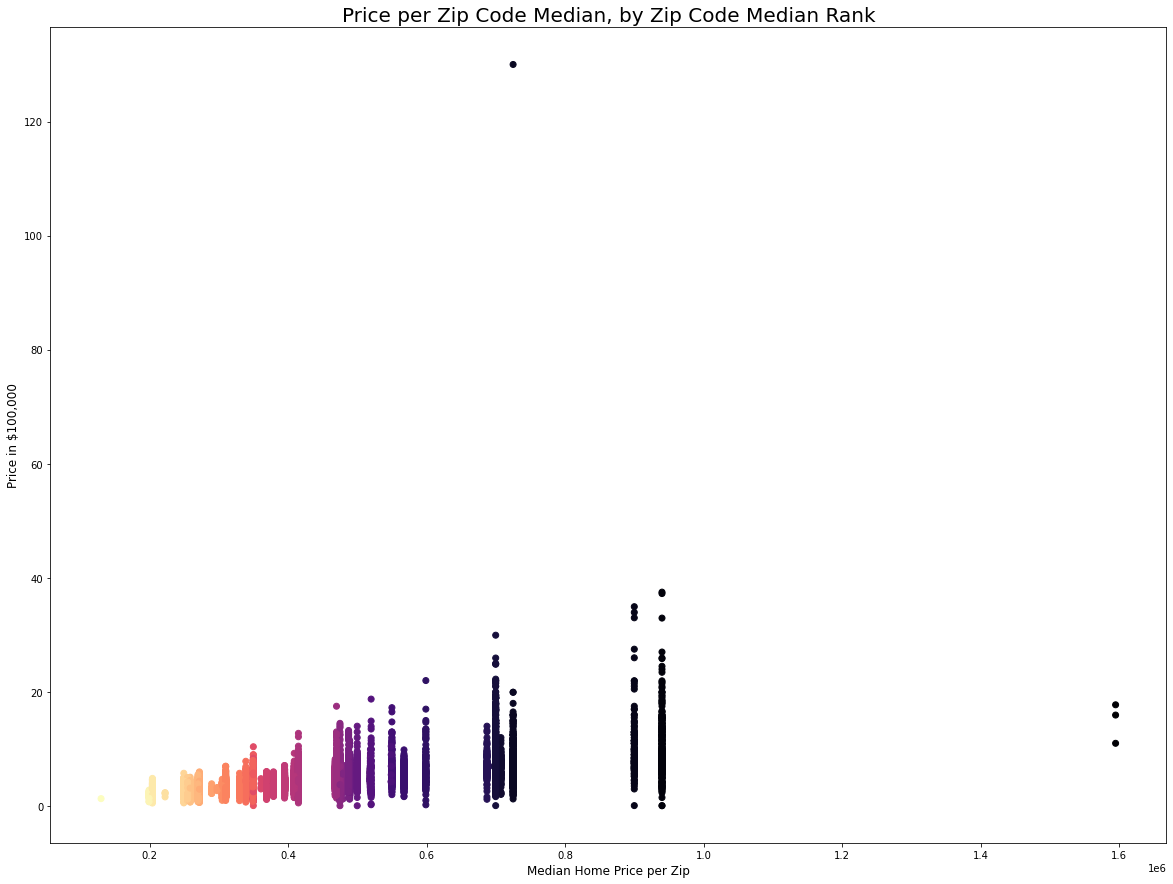

In [48]:
# visualize zip code as a color function

fig, ax = plt.subplots(figsize=(20, 15))

ax.scatter(df['median_zip'], df['price'] /100000, c=df['zip_rank'], cmap='magma_r')

ax.set_xlabel('Median Home Price per Zip', fontsize=12)
ax.set_ylabel('Price in $100,000', fontsize=12)
ax.set_title('Price per Zip Code Median, by Zip Code Median Rank', fontsize=20)
;

We can see that a few of our zip codes are very high value. There are also some clear outliers in this data set. We'll take care of removing those, and then come back to this visual again later after we've done some cleanup.

''

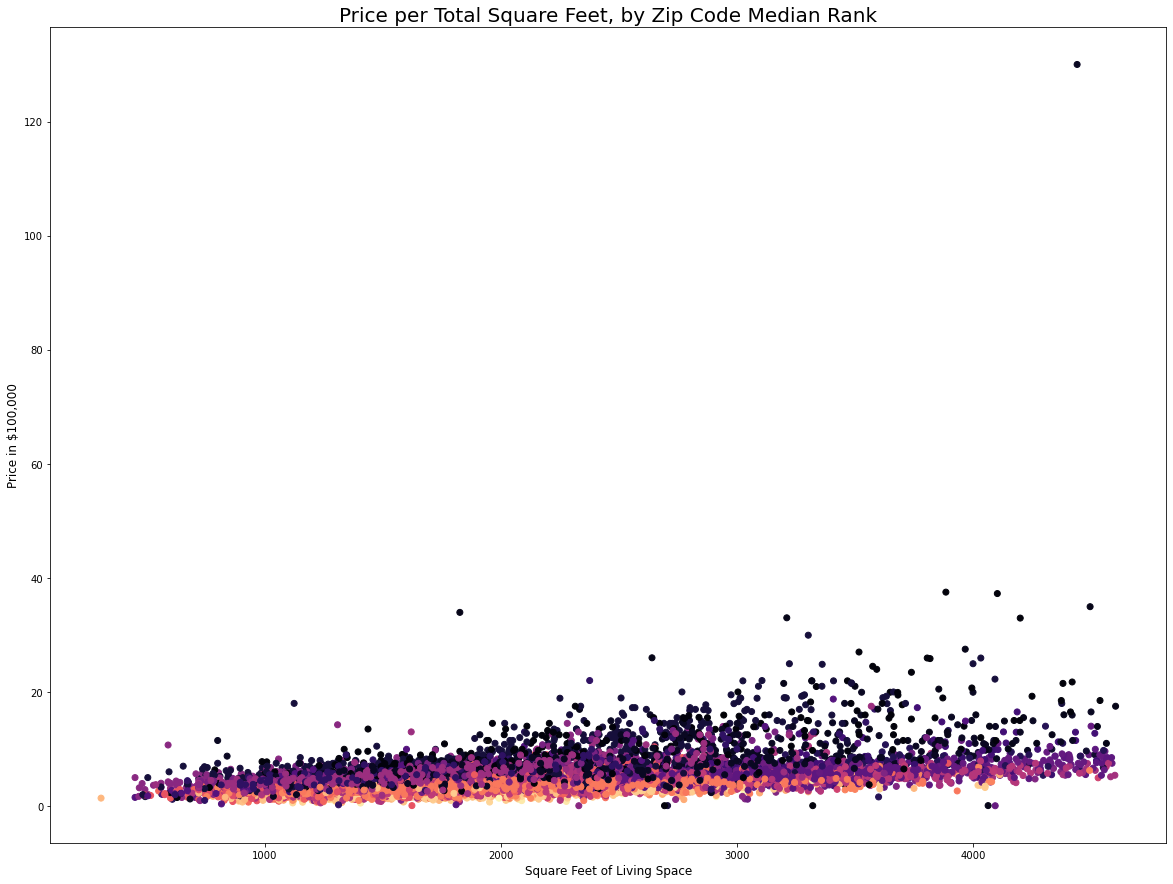

In [49]:
# visualize zip code as a color function, on a plot of price per square footage

fig, ax = plt.subplots(figsize=(20, 15))

ax.scatter(df['livingAreaSqFt'], df['price'] /100000, c=df['zip_rank'], cmap='magma_r')

ax.set_xlabel('Square Feet of Living Space', fontsize=12)
ax.set_ylabel('Price in $100,000', fontsize=12)
ax.set_title('Price per Total Square Feet, by Zip Code Median Rank', fontsize=20)
;

In [50]:
# we're dropping the values above 3 million, and the 3 entries from zipcode 78734
df.drop(df[df['price']>3000000].index, inplace=True)
df.drop(df[df['zipcode']==78734].index, inplace=True)

# check price stats by zip code and displaying top 30 zip codes by mean
find_zip_outliers = df.groupby('zipcode')['price'].describe()
find_zip_outliers.sort_values('mean', ascending=False).head(35)
# very suspicious values in many zip codes for min

,count,mean,std,min,25%,50%,75%,max
zipcode,,,,,,,,
78703,264.0,1.018940e+06,494831.316483,6300.0,656750.00,930000.0,1325000.00,2700000.0
78746,114.0,1.009715e+06,467114.608637,7900.0,699999.25,899950.0,1249000.00,2750000.0
78704,667.0,8.367228e+05,445576.067740,7500.0,536250.00,699850.0,999450.00,2995000.0
78731,420.0,7.496376e+05,303215.621686,124000.0,557425.00,725000.0,876000.00,1995000.0
78730,106.0,7.049658e+05,220979.656989,118499.0,569225.00,687250.0,829925.00,1400000.0
78738,1.0,6.970000e+05,NaN,697000.0,697000.00,697000.0,697000.00,697000.0
78756,133.0,6.803116e+05,332268.211346,21500.0,449900.00,599000.0,839000.00,2200000.0
78733,114.0,6.757573e+05,195457.693287,205000.0,549250.00,707450.0,799000.00,1200000.0
78701,7.0,6.395429e+05,252778.413221,415000.0,432450.00,549000.0,799450.00,1049000.0


In [51]:
# anything under 75k is no way a legitimate market value sale. 
# anything in this range is certainly a inter-family sale,
# non-commercial, some weird sale type.
# We are dropping all of those. 
df.drop(df.loc[(df['price'] <= 75000)].index, axis=0, inplace=True)

In [52]:
# Eliminating outliers on a per-zipcode basis using our IQR 1.6

zipcodes = df['zipcode'].unique()

for i in zipcodes:
    lower, upper = iqr_outliers(df[df['zipcode'] == i]['price'], 1.6)
    df.drop(df[ ( (df.price > upper) & (df['zipcode'] == i) ) | ( (df.price < lower)  & (df['zipcode'] == i) ) ].index , inplace=True)


In [53]:
'''#We can check our price per zip code histograms.

df['price'].hist(by=df['zipcode'], figsize=(30,30));    

# some of our zip codes don't have enough sales to give us information'''

"#We can check our price per zip code histograms.\n\ndf['price'].hist(by=df['zipcode'], figsize=(30,30));    \n\n# some of our zip codes don't have enough sales to give us information"

In [54]:
# We're going to drop our few zip codes where we have only a couple of data points

df.drop( df.loc[(df['zipcode']==78653) | (df['zipcode']==78738) | (df['zipcode']==78719)| (df['zipcode']==78652)| (df['zipcode']==78742)].index, axis=0, inplace=True)

### Cleanup

In [55]:
# combine all school counts into a single field
df['numOfSchools'] = df['numOfPrimarySchools'] + df['numOfElementarySchools'] + df['numOfMiddleSchools'] + df['numOfHighSchools']

In [56]:
# there is only ONE listing with 5 schools, so we will change that one to 4
df.loc[df['numOfSchools']==5, 'numOfSchools'] = 4

In [57]:
# convert original boolean columns to binary 0/1
boolean = ['hasAssociation', 'hasCooling', 'hasGarage', 'hasHeating', 'hasSpa', 'hasView']

for item in boolean:
    df[boolean] = df[boolean].astype(int)

In [58]:
# reset indices on original data frame before making a copy
df.reset_index(inplace=True)
df.drop('index', axis=1, inplace=True)

## Natural Language Processing

Our data set includes the listing text for each sale. We're going to use Natural Language Processing methods to extract relevant information from the listing text to boost the effectiveness of our model.

We're using spaCy and after basic package installation, we also need to download the english language pipeline.

In [59]:
# Load spaCy with English language processor
nlp = spacy.load("en_core_web_sm")

'''# add real estate related stop words to default stop word list
nlp.Defaults.stop_words |= {"bedroom", "bathroom","bath","home", "austin", "tx", "pron", "sq", "ft", "rent", "mo",
                            "w", "bed", 'single', 'family', 'contain', 'st', 'dr', 'square', 'foot', 'room', 'square', 'feet',
                            '-pron-', 'garage', 'pflugerville', 'story', '1st', '1story', '2car', '2nd',
                            '2story', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th', 'street', 'avenue', 'ave', 
                            'sac', 
                            
                           }

nlp.Defaults.stop_words.remove('is')
nlp.Defaults.stop_words.remove('as')'''

In [60]:
'''# copy the description column to a new data frame for text processing
listing_text = pd.DataFrame(df['description'])

listing_text['sentences'] = None

listing_text['sentences'] = listing_text['description'].apply(lambda x: text_block_processor(x))
    
# drop the description field and save our listing_text to file so we don't have to run it again
listing_text.drop('description', axis=1, inplace=True)

listing_text.to_pickle("listing_text.pkl")'''

In [61]:
# loading our cleaned listing descriptions from file and saving those to a data frame
listing_desc = pd.read_pickle("listing_text.pkl")
listing_desc

,sentences
0,DEFAULT
1,absolutely gorgeous locate tuck away communit...
2,construction estimate completion august pione...
3,absolutely darle charming book like lake nort...
4,brim appeal warm livability sleek stylish mod...
...,...
13084,nestle mature shade tree locate establish nei...
13085,beautiful texas oak huge cover patio neighbo...
13086,contemporary detach condo convenience downtow...
13087,original bungalow modern addition large corne...


In [62]:
# append our listing text to our original data frame
df = pd.concat([df, listing_desc], axis=1)

df

,zpid,city,streetAddress,zipcode,description,latitude,longitude,propertyTaxRate,garageSpaces,hasAssociation,hasCooling,hasGarage,hasHeating,hasSpa,hasView,homeType,parkingSpaces,yearBuilt,price,numPriceChanges,sale_date,latestPriceSource,numOfPhotos,numOfAccessibilityFeatures,numOfAppliances,numOfParkingFeatures,numOfPatioAndPorchFeatures,numOfSecurityFeatures,numOfWaterfrontFeatures,numOfWindowFeatures,numOfCommunityFeatures,lotSizeSqFt,livingAreaSqFt,numOfPrimarySchools,numOfElementarySchools,numOfMiddleSchools,numOfHighSchools,avgSchoolDistance,avgSchoolRating,avgSchoolSize,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories,homeImage,zip_rank,median_zip,numOfSchools,sentences
0,111373431,pflugerville,14424 Lake Victor Dr,78660,"14424 Lake Victor Dr, Pflugerville, TX 78660 i...",30.430632,-97.663078,1.98,2,1,1,1,1,0,0,Single Family,2,2012,305000.0,5,2019-09,"Coldwell Banker United, Realtors - South Austin",39,0,5,2,1,3,0,1,0,6011.0,2601.0,1,0,1,1,1.266667,2.666667,1063,14,3.0,4,2,111373431_ffce26843283d3365c11d81b8e6bdc6f-p_f...,10,289700.0,3,DEFAULT
1,120900430,pflugerville,1104 Strickling Dr,78660,Absolutely GORGEOUS 4 Bedroom home with 2 full...,30.432673,-97.661697,1.98,2,1,1,1,1,0,0,Single Family,2,2013,295000.0,1,2020-10,Agent Provided,29,0,1,2,0,0,0,0,0,6185.0,1768.0,1,0,1,1,1.400000,2.666667,1063,14,2.0,4,1,120900430_8255c127be8dcf0a1a18b7563d987088-p_f...,10,289700.0,3,absolutely gorgeous locate tuck away communit...
2,2084491383,pflugerville,1408 Fort Dessau Rd,78660,Under construction - estimated completion in A...,30.409748,-97.639771,1.98,0,1,1,0,1,0,0,Single Family,0,2018,256125.0,1,2019-07,Agent Provided,2,0,4,1,0,1,0,0,0,7840.0,1478.0,0,2,1,1,1.200000,3.000000,1108,14,2.0,3,1,2084491383_a2ad649e1a7a098111dcea084a11c855-p_...,10,289700.0,4,construction estimate completion august pione...
3,120901374,pflugerville,1025 Strickling Dr,78660,Absolutely darling one story home in charming ...,30.432112,-97.661659,1.98,2,1,1,1,1,0,0,Single Family,2,2013,240000.0,4,2018-08,Agent Provided,9,0,0,2,0,0,0,0,0,6098.0,1678.0,1,0,1,1,1.400000,2.666667,1063,14,2.0,3,1,120901374_b469367a619da85b1f5ceb69b675d88e-p_f...,10,289700.0,3,absolutely darle charming book like lake nort...
4,60134862,pflugerville,15005 Donna Jane Loop,78660,Brimming with appeal & warm livability! Sleek ...,30.437368,-97.656860,1.98,0,1,1,0,1,0,0,Single Family,0,2002,239900.0,3,2018-10,Agent Provided,27,0,0,1,0,0,0,0,0,6708.0,2132.0,1,0,1,1,1.133333,4.000000,1223,14,3.0,3,2,60134862_b1a48a3df3f111e005bb913873e98ce2-p_f.jpg,10,289700.0,3,brim appeal warm livability sleek stylish mod...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13084,29504086,austin,9013 Marsh Dr,78748,This 3 bedroom home is nestled among mature sh...,30.185915,-97.828415,1.98,2,0,1,1,1,1,0,Single Family,2,1983,280000.0,1,2020-11,Agent Provided,63,0,3,2,3,1,0,0,0,8058.0,1420.0,1,0,1,1,2.133333,5.666667,1537,16,2.0,3,1,29504086_f55db59cbebad30d475f31e6aee0d020-p_f.jpg,13,309945.0,3,nestle mature shade tree locate establish nei...
13085,29512934,austin,905 Silcantu Dr,78748,Not for rent!\n\nBeautiful one story home in T...,30.161997,-97.816345,1.98,3,0,1,1,1,0,1,Single Family,5,1986,330000.0,1,2020-12,Agent Provided,49,0,3,2,4,0,0,0,0,6534.0,1234.0,1,0,1,1,0.900000,3.333333,1424,14,2.0,3,1,29512934_ff9b6eefa7e2eb4e9ef983da13a23098-p_f.jpg,13,309945.0,3,beautiful texas oak huge cover patio neighbo...
13086,241937773,austin,1413 Waterloo Shore Ln UNIT 12,78741,This contemporary three-story detached condo h...,30.240223,-97.772835,1.98,2,1,1,1,1,1,1,Single Family,2,2016,550000.0,1,2020-12,Agent Provided,32,1,5,2,2,1,0,0,0,2439.0,1888.0,1,0,1,1,1.900000,6.666667,1226,16,4.0,3,3,241937773_66d3e483bd783eac5a52ff5f938d2a2e-p_f...,17,349900.0,3,contemporary detach condo convenience downtow...
13087,29473281,austin,2206 S 3rd St,7

In [63]:
df.drop('description', axis=1, inplace=True)

# Cleaning Final Data

In [64]:
df_images = pd.DataFrame(df['homeImage'])
df_images

,homeImage
0,111373431_ffce26843283d3365c11d81b8e6bdc6f-p_f...
1,120900430_8255c127be8dcf0a1a18b7563d987088-p_f...
2,2084491383_a2ad649e1a7a098111dcea084a11c855-p_...
3,120901374_b469367a619da85b1f5ceb69b675d88e-p_f...
4,60134862_b1a48a3df3f111e005bb913873e98ce2-p_f.jpg
...,...
13084,29504086_f55db59cbebad30d475f31e6aee0d020-p_f.jpg
13085,29512934_ff9b6eefa7e2eb4e9ef983da13a23098-p_f.jpg
13086,241937773_66d3e483bd783eac5a52ff5f938d2a2e-p_f...
13087,29473281_9e90ec4652c4b3b6592a7fdd09f1ea6d-p_f.jpg


In [65]:
df.drop(['zpid', 'city', 'streetAddress', 'latestPriceSource',  'homeImage',
       'numOfElementarySchools', 'numOfMiddleSchools', 'numOfPrimarySchools', 'numOfSchools', 
         'median_zip', 'zip_rank',
       'parkingSpaces',  'hasGarage', 'numOfParkingFeatures'], axis=1, inplace=True)

## Train/Test Split

We need to create our holdout data before any further processing.

The reasons for this are:
   * We will standardize our continuous variables, and you should standardize only on your train set and apply that to your test set.
   * We will be feature engineering on our train set, and applying that later to our test set. We cannot have our test set data leak into our engineered features.
   * We'll be doing some natural language processing, fitting on our train set and applying to our test set. We don't want data leakage for the same reasons as above.
    

In [66]:
#y = np.log(df['price'])
nlp = df['sentences']
the_rest = df.drop('sentences', axis=1)

In [67]:
y = pd.DataFrame(np.log(df['price']))
# get min and max for binning

y.describe()

,price
count,13089.000000
mean,12.898563
std,0.434679
min,11.277203
25%,12.611204
50%,12.873902
75%,13.160622
max,14.667796


In [68]:
# I enter the min price, max price, and how many bins I want
bins = np.linspace(y['price'].min(), y['price'].max()+.01, 5)

# numpy sorts the indices into the proper bins based on value of y
y_binned = np.digitize(y, bins)

In [69]:
# split continuous, categorical, nlp and target
train, holdout, y_train, y_test = train_test_split(the_rest, y, test_size=0.15, random_state=randomstate, stratify=y_binned)
nlp_train, nlp_holdout = train_test_split(nlp, test_size=0.15, random_state=randomstate, stratify=y_binned)

# reset indices to prevent any index mismatches
train.reset_index(inplace=True, drop=True)
holdout.reset_index(inplace=True, drop=True)
nlp_train.reset_index(inplace=True, drop=True)
nlp_holdout.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

In [70]:
'''# split continuous, categorical, nlp and target
train, holdout, y_train, y_test = train_test_split(the_rest, y, test_size=0.2, random_state=randomstate)
nlp_train, nlp_holdout = train_test_split(nlp, test_size=0.2, random_state=randomstate)

# reset indices to prevent any index mismatches
train.reset_index(inplace=True, drop=True)
holdout.reset_index(inplace=True, drop=True)
nlp_train.reset_index(inplace=True, drop=True)
nlp_holdout.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)'''

'# split continuous, categorical, nlp and target\ntrain, holdout, y_train, y_test = train_test_split(the_rest, y, test_size=0.2, random_state=randomstate)\nnlp_train, nlp_holdout = train_test_split(nlp, test_size=0.2, random_state=randomstate)\n\n# reset indices to prevent any index mismatches\ntrain.reset_index(inplace=True, drop=True)\nholdout.reset_index(inplace=True, drop=True)\nnlp_train.reset_index(inplace=True, drop=True)\nnlp_holdout.reset_index(inplace=True, drop=True)\ny_train.reset_index(inplace=True, drop=True)\ny_test.reset_index(inplace=True, drop=True)'

## Process Categoricals

In [71]:
categories = ['zipcode', 'homeType', 'sale_date', 'numOfHighSchools', 'propertyTaxRate']

df_categoricals_train = train[categories]
df_categoricals_holdout = holdout[categories]

# telling Pandas that these columns are categoricals
for item in df_categoricals_train.columns:
    df_categoricals_train[item] = df_categoricals_train[item].astype('category')
    
    # telling Pandas that these columns are categoricals
for item in df_categoricals_holdout.columns:
    df_categoricals_holdout[item] = df_categoricals_holdout[item].astype('category')
    
df_categoricals_train = pd.get_dummies(df_categoricals_train, prefix=categories, drop_first=True)
df_categoricals_holdout = pd.get_dummies(df_categoricals_holdout, prefix=categories, drop_first=True)

## Process Continuous

##### Target Encoding

In [72]:
# target encoding on train and holdout

train = target_encoding(train, train)
holdout = target_encoding(train, holdout)

##### Dropping unneeded fields

In [73]:
# dropping unnecessary things

train_cont = train.drop(['zipcode', 'propertyTaxRate', 'homeType', 'sale_date', 'numOfHighSchools', 
                         'price', 'latitude', 'longitude', 'lat_zone', 'long_zone', 'lat_smooth', 'long_smooth'], axis=1)
holdout_cont = holdout.drop(['zipcode', 'propertyTaxRate', 'homeType', 'sale_date', 'numOfHighSchools', 
                             'price', 'latitude', 'longitude', 'lat_zone', 'long_zone', 'lat_smooth', 'long_smooth'], axis=1)

##### Standardization

In [74]:
# standardize all of our values with scikit-learn MinMaxScaler to normalize the data for NN usage
scaler = MinMaxScaler()

#transformed_scaled_continuous = pd.DataFrame(scaler.fit_transform(x_train_cont_log),columns = x_train_cont_log.columns)
scaled_train = pd.DataFrame(scaler.fit_transform(train_cont),columns = train_cont.columns)
scaled_holdout = pd.DataFrame(scaler.transform(holdout_cont),columns = holdout_cont.columns)

##### Add polynomial features

In [75]:
year_poly_t = create_polynomial_array(scaled_train, 'yearBuilt',2)
year_poly_h = create_polynomial_array(scaled_holdout, 'yearBuilt',2)

scaled_train['year2'] = year_poly_t[1]
scaled_holdout['year2'] = year_poly_h[1]

## Process NLP 

We're now going to use natural language processing on our listing descriptions, which we cleaned earlier in the notebook using SpaCy.

In [76]:
# make a new dataframe with just the descriptions from our train data

nlp_train = pd.DataFrame(nlp_train)
nlp_holdout = pd.DataFrame(nlp_holdout)

We're going to pull relevant information from the listing descriptions with the following parameters:
   * sublinear_tf = True: A weight scaler that reduces the bias of assuming that an ngram that appears x times more frequently is x times more important
   * use_idf = True: use Inverse Document Frequency, so that ngrams that appear very frequently to the extent they appear in most document (i.e., a bad indicator) get weighted less compared to ngrams that appear less frequently but they appear in specific documents only (i.e., a good indicator)(citation: https://stackoverflow.com/questions/34435484/tfidfvectorizer-normalisation-bias) 
   * max_df: the maximum % of documents where an ngram can appear to be utilized
   * min_df: the minimum % of documents where an ngram must appear to be utilized
   * ngram_range=(x,y): the types of ngrams we will create, from x to y
   * max_features: the maximum number of features that will be created
   
TfidfVectorizer then creates a binary array for all of the features selected, and assigns the word a weight based on its frequency and importance.

In [77]:
# prepare the vectorizer with the chosen parameters
processor = TfidfVectorizer(sublinear_tf=True, use_idf=True, max_df=0.9, min_df=.005, ngram_range=(1,2), max_features=1000)
# fit the vectorizer to the data
x = processor.fit_transform(nlp_train['sentences'])

# cast the vector array to a data frame with columns named by the features selected by the vectorizer
train_word_vectors = pd.DataFrame(x.toarray(), columns=processor.get_feature_names())

In [78]:
# run a test model using the word vectors
predictors_train = sm.add_constant(train_word_vectors)
model = sm.OLS(y_train, predictors_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.424
Model:                            OLS   Adj. R-squared:                  0.367
Method:                 Least Squares   F-statistic:                     7.470
Date:                Fri, 22 Oct 2021   Prob (F-statistic):               0.00
Time:                        13:00:35   Log-Likelihood:                -3425.9
No. Observations:               11125   AIC:                             8852.
Df Residuals:                   10125   BIC:                         1.617e+04
Df Model:                         999                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    12.7287      0.023    565.076      0.000      12.685      12.773
abundance                 0.0334      0.240      0.139      0.889      -0.436       0.503
abundance natural         0.0634      0.291      0.218      0.828      -0.508       0.634
abundant                  0.4092      0.165      2.483      0.013       0.086       0.732
ac                        0.0335      0.134      0.250      0.803      -0.230       0.297
accent                    0.1334      0.165      0.810      0.418      -0.189       0.456
access                    0.2468      0.143      1.729      0.084      -0.033       0.527
access downtown          -0.0979      0.196     -0.500      0.617      -0.482       0.286
access mopac              0.0991      0.198      0.502      0.616      -0.288       0.486
acre                      0.2117      0.132      1.606      0.108      -0.047       0.470
acre lot                 -0.0020      0.181     -0.011      0.991      -0.357       0.353
add                      -0.1346      0.106     -1.268      0.205      -0.343       0.073
addition                  0.4438      0.144      3.090      0.002       0.162       0.725
additional                0.1229      0.120      1.023      0.306      -0.113       0.358
adorable                 -0.5108      0.141     -3.631      0.000      -0.787      -0.235
agent                     0.0028      0.127      0.022      0.982      -0.246       0.252
air                       0.2739      0.169      1.621      0.105      -0.057       0.605
airport                  -0.4712      0.129     -3.655      0.000      -0.724      -0.218
airy                      0.1241      0.178      0.697      0.486      -0.225       0.473
alamo                    -0.0722      0.190     -0.380      0.704      -0.444       0.300
allow                     0.2840      0.139      2.043      0.041       0.011       0.556
amazing                   0.0140      0.098      0.144      0.886      -0.177       0.205
amenity                  -0.2417      0.140     -1.724      0.085      -0.517       0.033
amenity include          -0.0076      0.208     -0.037      0.971      -0.416       0.401
ample                     0.1527      0.142      1.077      0.281      -0.125       0.431
anderson                  0.3349      0.184      1.824      0.068      -0.025       0.695
appeal                    0.4993      0.336      1.488      0.137      -0.158       1.157
apple                     0.1350      0.220      0.615      0.539      -0.295       0.565
apple campus              0.1541      0.318      0.485      0.628      -0.469       0.777
appliance                 0.2977      0.169      1.763      0.078      -0.033       0.629
appliance granite        -0.1046      0.170     -0.614      0.539      -0.439       0.229
appliance new          

Now we will use permutation importance to determine which of these words is actually relevant to our model. This is a great model-agnostic method that you can use with any model type, and the way it works is very easy to understand. After fitting the model, it calculates a baseline R^2 score. Then for each feature, it scrambles the inputs of that feature, turnings its contribution into noise. The model is evaluated again with the feature scrambled, and the change in overall R^2 is logged as the importance for that feature. After scrambling all features, each feature has been assigned an importance based on the R^2 reduction. You can then select the features that had an effect on R^2 based on your own threshold (I kept anything >= .001) and throw out the remaining features.

You can learn more about this underrated feature selection method here: https://explained.ai/rf-importance/ The article focuses on Random Forest, but discusses permutation importance as an excellent feature selection method for any model type.

In [79]:
'''model = LinearRegression()
model.fit(train_word_vectors, y_train)

from sklearn.inspection import permutation_importance
r = permutation_importance(model, train_word_vectors, y_train,
                           n_repeats=10,
                            random_state=0,
                          n_jobs=-1)

importances = {}

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] >= 0.002:
        importances[train_word_vectors.columns[i]] = r.importances_mean[i]
    else: continue
        
importances

important_ngrams = list(importances.keys())
print(important_ngrams)'''

'model = LinearRegression()\nmodel.fit(train_word_vectors, y_train)\n\nfrom sklearn.inspection import permutation_importance\nr = permutation_importance(model, train_word_vectors, y_train,\n                           n_repeats=10,\n                            random_state=0,\n                          n_jobs=-1)\n\nimportances = {}\n\nfor i in r.importances_mean.argsort()[::-1]:\n    if r.importances_mean[i] >= 0.002:\n        importances[train_word_vectors.columns[i]] = r.importances_mean[i]\n    else: continue\n        \nimportances\n\nimportant_ngrams = list(importances.keys())\nprint(important_ngrams)'

In [80]:
important_ngrams = ['de', 'default', 'stainless steel', 'cul de', 'steel', 'washer dryer', 'pool', 'main', 'dryer', 'open concept', 'country', 'barton', 'zilker', 'mid century', 'cul', 'concept', 'golf course', 'outdoor', 'heart', 'hardwood', 'washer', 'wine', 'view', 'laminate', 'i35', 'south', 'steiner ranch', 'course', 'condo', 'restaurant', 'century', 'minute', 'design', 'gourmet kitchen', 'northwest', 'park pool', 'tankless', 'easy access', 'community', 'paint', 'luxury', 'curb', 'level', 'conveniently locate', 'isd', 'water heater', 'office', 'yes', 'finish', 'steiner', 'hill country', 'great', 'community pool', 'conveniently', 'classic', 'brand new', 'circle', 'storage building', 'marble', 'elementary', 'mopac', 'ut', 'walnut', 'guest', 'investment', 'flat', 'mckinney', 'media', 'plantation', 'walnut creek', 'vinyl', 'freshly paint', 'south congress', 'build', 'suite', 'burn', 'formal', 'airport', 'google fiber', 'window']

In [81]:
len(important_ngrams)

80

The feature selector designated only 74 of the 1000 ngrams that it created as important. The remaining ngrams will be discarded.

These are copied just above so that the selector code does not need to be run every time.

In [82]:
train_word_vectors_refined = train_word_vectors[important_ngrams]

# transform our holdout set using the same vectorizer as our train set (it will make the same set of ngrams)
x = processor.transform(nlp_holdout['sentences'])

# cast our word vectors to data frame
holdout_word_vectors = pd.DataFrame(x.toarray(), columns=processor.get_feature_names())

# refine the holdout words to the same as the train set
holdout_word_vectors_refined = holdout_word_vectors[important_ngrams]

## Concat Train/Test Sets

In [348]:
X_train = pd.concat([df_categoricals_train, scaled_train, train_word_vectors_refined], axis=1)
X_test = pd.concat([df_categoricals_holdout, scaled_holdout, holdout_word_vectors_refined], axis=1)

# Model Explorations

We're going to evaluate a few different variations of our linear regression model, as well as a few more complex model types. In order to keep track of our results, we'll be making a dictionary to store our model accuracy results.

In [335]:
# prepare dictionary to store results
models = {}
models['model'] = []
models['r2'] = []
models['mae'] = []
models['rmse'] = [] 

## Spot Check Models

In [85]:
'''# Set upline models
baseline_models = {
    "LR": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state = randomstate),
    "Elastic Net": ElasticNet(random_state = randomstate, normalize=True, copy_X=True, tol=1e-3),
    "Extra Trees": ExtraTreesRegressor(random_state = randomstate),
    "Gaussian": GaussianProcessRegressor(random_state = randomstate, normalize_y=True),
    "Gradient Boosted" : GradientBoostingRegressor(random_state = randomstate),
    "KNN" : KNeighborsRegressor(),
    "Lars" : Lars(random_state = randomstate, copy_X=True, normalize=False),
    "Lasso" : Lasso(random_state = randomstate, copy_X=True, tol=1e-3),
    "LinearSVR" : LinearSVR(random_state = randomstate),
    "MLPRegressor" : MLPRegressor(random_state = randomstate),
    "Bayesian Ridge" : BayesianRidge(),
    "Gamma Regressor" : GammaRegressor(),
    "Lasso Lars" : LassoLars(random_state = randomstate, normalize=False, copy_X=True),
    "Nu SVR": NuSVR(),
    "Orthogonal Matching Pursuit" : OrthogonalMatchingPursuit(),
    "Passive Aggressive" : PassiveAggressiveRegressor(random_state = randomstate),
    "RANSAC" : RANSACRegressor(random_state = randomstate),
    "Ridge" : Ridge(random_state = randomstate, tol=1e-3, normalize=False),
    "SVR" : SVR(),
    "XGB Regressor" : xgb.XGBRegressor(random_state = randomstate),
    "Ada Boost" : AdaBoostRegressor(random_state=randomstate),
    "SGD Regressor" : SGDRegressor(random_state=randomstate),
    "Random Forest Regressor" : RandomForestRegressor(random_state=randomstate)
}

# run spot check on each model inline
for model in baseline_models:
    this_model = baseline_models[model]
    label = model
    spot_check = score_model(this_model, X_train, y_train, label, models)'''

'# Set upline models\nbaseline_models = {\n    "LR": LinearRegression(),\n    "Decision Tree": DecisionTreeRegressor(random_state = randomstate),\n    "Elastic Net": ElasticNet(random_state = randomstate, normalize=True, copy_X=True, tol=1e-3),\n    "Extra Trees": ExtraTreesRegressor(random_state = randomstate),\n    "Gaussian": GaussianProcessRegressor(random_state = randomstate, normalize_y=True),\n    "Gradient Boosted" : GradientBoostingRegressor(random_state = randomstate),\n    "KNN" : KNeighborsRegressor(),\n    "Lars" : Lars(random_state = randomstate, copy_X=True, normalize=False),\n    "Lasso" : Lasso(random_state = randomstate, copy_X=True, tol=1e-3),\n    "LinearSVR" : LinearSVR(random_state = randomstate),\n    "MLPRegressor" : MLPRegressor(random_state = randomstate),\n    "Bayesian Ridge" : BayesianRidge(),\n    "Gamma Regressor" : GammaRegressor(),\n    "Lasso Lars" : LassoLars(random_state = randomstate, normalize=False, copy_X=True),\n    "Nu SVR": NuSVR(),\n    "Orth

In [86]:
'''# make data frame from our models dictionary
target = pd.DataFrame(models).reset_index(drop=True)

# sort data frame by mae and reset index
target.sort_values('mae', ascending=False).head(20)'''

"# make data frame from our models dictionary\ntarget = pd.DataFrame(models).reset_index(drop=True)\n\n# sort data frame by mae and reset index\ntarget.sort_values('mae', ascending=False).head(20)"

### Feature Selectors

Feature selectors are different methods to help us pick which features we want to use in our model. In our example above where we used ALL predictors in our linear regression, several of our features had a p-value over .05, which indicates that there is more than a 5% chance that the changes attributed to that feature were actually by random chance. We want features where our p-value is below a threshold that we specify where we are reasonably confident that the feature is contributing to the model and not by random chance.

In [87]:
'''# Unless we specify a different model, this is our baseline model
model = NuSVR()'''

'# Unless we specify a different model, this is our baseline model\nmodel = NuSVR()'

In [88]:
'''predictors_train = sm.add_constant(X_train)
modelols = sm.OLS(y_train, predictors_train).fit()
modelols.summary()'''

'predictors_train = sm.add_constant(X_train)\nmodelols = sm.OLS(y_train, predictors_train).fit()\nmodelols.summary()'

##### Forward-Backward Selector

Now we'll try a simple forward-backward feature selection model based on p-value, using a statsmodel OLS linear regression model. This selector starts with zero features, internally runs the model for each feature individually, and adds the lowest p-value feature to its list to include. It then runs the model again with the original feature included and tries adding each other feature individually. It will either add the next best feature under the threshold or remove an existing feature if it is no longer within the threshold. This process iterates until all features in the model are under the p-value threshold.

This model takes quite some time to run, so is commented out with the results replicated in markdown following.

In [89]:
'''result = stepwise_selection(X_train, y_train, verbose=True)

print('resulting features:', result)


#result = ['livingAreaSqFt', 'hasAssociation', 'zip_smooth', 'numPriceChanges', 'year_smooth', 'month_smooth', 'zipcode_78725', 'zipcode_78745', 'zipcode_78748', 'avgSchoolRating', 'zipcode_78732', 'propertyTaxRate_2.21', 'lat_long', 'avgSchoolSize', 'zipcode_78737', 'zipcode_78754', 'zipcode_78739', 'numOfPatioAndPorchFeatures', 'zipcode_78726', 'design', 'homeType_Single Family', 'great', 'numOfPhotos', 'zipcode_78746', 'zipcode_78660', 'zipcode_78756', 'lotSizeSqFt', 'zipcode_78701', 'year2', 'yearBuilt', 'zipcode_78757', 'hasCooling', 'zipcode_78723', 'condo', 'zipcode_78705', 'outdoor', 'washer', 'zipcode_78702', 'zipcode_78729', 'numOfStories', 'numOfBathrooms', 'zipcode_78758', 'luxury', 'sale_date_2020-12', 'zipcode_78751', 'zipcode_78722', 'zipcode_78721', 'zipcode_78741', 'zipcode_78749', 'avgSchoolDistance', 'numOfSecurityFeatures', 'garageSpaces', 'zipcode_78727', 'homeType_Townhouse', 'wine', 'sale_date_2018-02', 'sale_date_2018-05', 'sale_date_2018-08', 'barton', 'community pool', 'tankless', 'sale_date_2018-04', 'hasSpa', 'zipcode_78752', 'zipcode_78759', 'zipcode_78753', 'zipcode_78728', 'zipcode_78750', 'zipcode_78744', 'zipcode_78717', 'view', 'sale_date_2018-03', 'parking', 'formal', 'zipcode_78735', 'school', 'sale_date_2018-06', 'steel', 'laminate', 'classic', 'numOfAppliances']'''

"result = stepwise_selection(X_train, y_train, verbose=True)\n\nprint('resulting features:', result)\n\n\n#result = ['livingAreaSqFt', 'hasAssociation', 'zip_smooth', 'numPriceChanges', 'year_smooth', 'month_smooth', 'zipcode_78725', 'zipcode_78745', 'zipcode_78748', 'avgSchoolRating', 'zipcode_78732', 'propertyTaxRate_2.21', 'lat_long', 'avgSchoolSize', 'zipcode_78737', 'zipcode_78754', 'zipcode_78739', 'numOfPatioAndPorchFeatures', 'zipcode_78726', 'design', 'homeType_Single Family', 'great', 'numOfPhotos', 'zipcode_78746', 'zipcode_78660', 'zipcode_78756', 'lotSizeSqFt', 'zipcode_78701', 'year2', 'yearBuilt', 'zipcode_78757', 'hasCooling', 'zipcode_78723', 'condo', 'zipcode_78705', 'outdoor', 'washer', 'zipcode_78702', 'zipcode_78729', 'numOfStories', 'numOfBathrooms', 'zipcode_78758', 'luxury', 'sale_date_2020-12', 'zipcode_78751', 'zipcode_78722', 'zipcode_78721', 'zipcode_78741', 'zipcode_78749', 'avgSchoolDistance', 'numOfSecurityFeatures', 'garageSpaces', 'zipcode_78727', 'home

In [90]:
'''# Run our linear regression again, using only the features recommended by our feature selector

X_train_refined = X_train[result]

predictors_int = sm.add_constant(X_train_refined)
model1 = sm.OLS(y_train, predictors_int).fit()
model1.summary()'''

'# Run our linear regression again, using only the features recommended by our feature selector\n\nX_train_refined = X_train[result]\n\npredictors_int = sm.add_constant(X_train_refined)\nmodel1 = sm.OLS(y_train, predictors_int).fit()\nmodel1.summary()'

In [91]:
#models = score_model(model, X_train_refined, y_train, "NuSVR Forward Backward", models)

##### Permutation Importance

In [92]:
'''model1 = LinearRegression()
model1.fit(X_train, y_train)

from sklearn.inspection import permutation_importance
r = permutation_importance(model1, X_train, y_train,
                           n_repeats=15,
                            random_state=0,
                          n_jobs=-1)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] >= 0.001:
        print(f"{X_train.columns[i]:<8} "
            f"\t\tImportance: {r.importances_mean[i]:.3f} ")
        
importances = {}

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] >= 0.001:
        importances[X_train.columns[i]] = r.importances_mean[i]
    else: continue
        
importances

important_features = list(importances.keys())
print(important_features)'''

'model1 = LinearRegression()\nmodel1.fit(X_train, y_train)\n\nfrom sklearn.inspection import permutation_importance\nr = permutation_importance(model1, X_train, y_train,\n                           n_repeats=15,\n                            random_state=0,\n                          n_jobs=-1)\n\nfor i in r.importances_mean.argsort()[::-1]:\n    if r.importances_mean[i] >= 0.001:\n        print(f"{X_train.columns[i]:<8} "\n            f"\t\tImportance: {r.importances_mean[i]:.3f} ")\n        \nimportances = {}\n\nfor i in r.importances_mean.argsort()[::-1]:\n    if r.importances_mean[i] >= 0.001:\n        importances[X_train.columns[i]] = r.importances_mean[i]\n    else: continue\n        \nimportances\n\nimportant_features = list(importances.keys())\nprint(important_features)'

In [93]:
'''permutation_x_train = X_train[important_features]

#models = score_model(model, permutation_x_train, y_train, "NuSVR Perm Importance", models)'''

'permutation_x_train = X_train[important_features]\n\n#models = score_model(model, permutation_x_train, y_train, "NuSVR Perm Importance", models)'

##### Recursive Feature Elimination with Cross Validation - Linear Regression

RFECV is a reverse forward-backward selector. It starts the model with all features in use then removes the weakest one, and iterates until the best feature set is found. It uses integrated cross-validation to determine the optimal set of features in the model with the best cross-validated score. We score on mean absolute error.

In [94]:
'''# Using sklearn RFECV to perform integrated CV while picking the number of features
# picks the number of features itself

model = LinearRegression(n_jobs=-4)
cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=1)

rfecv = RFECV(estimator=model, step=1, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-4)

# fit model to train set
rfecv.fit(X_train, y_train)

# print optimal number of features
print('Optimal number of features: {}'.format(rfecv.n_features_))'''

"# Using sklearn RFECV to perform integrated CV while picking the number of features\n# picks the number of features itself\n\nmodel = LinearRegression(n_jobs=-4)\ncv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=1)\n\nrfecv = RFECV(estimator=model, step=1, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-4)\n\n# fit model to train set\nrfecv.fit(X_train, y_train)\n\n# print optimal number of features\nprint('Optimal number of features: {}'.format(rfecv.n_features_))"

In [95]:
'''dset = pd.DataFrame()
dset['attr'] = X_train.columns
dset['used'] = rfecv.support_

# make a list of the features used in the rfecv
rfecv_result = list(dset[(dset['used'] == True)]['attr'])

# Show the features that RFECV did not use
dset[dset['used']==False]'''

"dset = pd.DataFrame()\ndset['attr'] = X_train.columns\ndset['used'] = rfecv.support_\n\n# make a list of the features used in the rfecv\nrfecv_result = list(dset[(dset['used'] == True)]['attr'])\n\n# Show the features that RFECV did not use\ndset[dset['used']==False]"

In [96]:
'''# Run our linear regression again in statsmodels, using the features recommended by our feature selector

X_train_rfecv = X_train[rfecv_result]

predictors_int = sm.add_constant(X_train_rfecv)
model2 = sm.OLS(y_train, predictors_int).fit()
model2.summary()'''

'# Run our linear regression again in statsmodels, using the features recommended by our feature selector\n\nX_train_rfecv = X_train[rfecv_result]\n\npredictors_int = sm.add_constant(X_train_rfecv)\nmodel2 = sm.OLS(y_train, predictors_int).fit()\nmodel2.summary()'

In [97]:
#models = score_model(model, X_train_rfecv, y_train, "NuSVR RFECV", models)

RFECV still includes features with a p-value over .05. Overall though, accuracy is higher than other feature selection methods.


In [98]:
'''plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('R2', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)

plt.show()'''

"plt.figure(figsize=(16, 9))\nplt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)\nplt.xlabel('Number of features selected', fontsize=14, labelpad=20)\nplt.ylabel('R2', fontsize=14, labelpad=20)\nplt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)\n\nplt.show()"

##### Principal Component Analysis

Explained variance with all components is  99.9999999999999
1 component explains  10.438246711422511
1st and 2nd components explains  15.941680126264714
1st to 3rd components explains  20.676602704241294
1st to 4th components explains  25.00975766550698


Text(0, 0.5, 'Explained Variance')

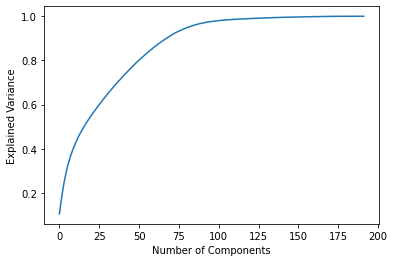

In [317]:
from sklearn.decomposition import PCA

pca_all = PCA(n_components=X_train.shape[1], random_state=randomstate)
x_pca = pca_all.fit_transform(X_train)

print("Explained variance with all components is ", sum(pca_all.explained_variance_ratio_ * 100))
print("1 component explains ", np.cumsum(pca_all.explained_variance_ratio_ * 100)[0])
print("1st and 2nd components explains ", np.cumsum(pca_all.explained_variance_ratio_ * 100)[1])
print("1st to 3rd components explains ", np.cumsum(pca_all.explained_variance_ratio_ * 100)[2])
print("1st to 4th components explains ", np.cumsum(pca_all.explained_variance_ratio_ * 100)[3])

plt.plot(np.cumsum(pca_all.explained_variance_ratio_))
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance")

In [337]:
# Reducing the dataset into principal components that explain 95% of the variance

pca_95th = PCA(n_components=.95, random_state=randomstate)
x_pca_95 = pca_95th.fit_transform(X_train)

print(x_pca_95.shape[1],"components, starting from all features")

82 components, starting from all features


In [322]:
model=NuSVR()
models = score_model(model, x_pca_95, y_train, "NuSVR PCA", models)



 NuSVR PCA  scores
CV 5 R2 Train Score: 74.8
CV 5 MAE Train Score: -0.1505
CV 5 RMSE Train Score: -0.2175


In [325]:
# make data frame from our models dictionary
target = pd.DataFrame(models).reset_index(drop=True)

# sort data frame by mae and reset index
target.sort_values('mae', ascending=False).head(20)

,model,r2,mae,rmse
2,NuSVR,78.79,-0.1320,-0.1995
1,NuSVR PCA,74.80,-0.1505,-0.2175
0,NuSVR PCA,71.18,-0.1671,-0.2327


## Tuned Models

In [103]:
y_exp_train = np.exp(y_train)
y_exp_test = np.exp(y_test)

In [104]:
nu_svr = NuSVR(kernel = 'rbf', gamma = 'scale', C=1, nu=.75)

nu_svr.fit(X_train, y_train)

NuSVR(C=1, nu=0.75)

In [105]:
test = X_test.fillna(X_test.mean())
predictions = nu_svr.predict(test)

In [106]:
pred_exp = np.exp(predictions)
actual = np.exp(y_test)

print("MAE: ",int(mean_absolute_error(pred_exp, actual)))
print("RMSE:",int(np.sqrt(mean_squared_error(pred_exp, actual))))
print("R2:", r2_score(pred_exp, actual)*100)

MAE:  61825
RMSE: 103949
R2: 71.92074786723887


In [107]:
break

SyntaxError: 'break' outside loop (Temp/ipykernel_30180/668683560.py, line 4)

## Neural Network

https://www.pyimagesearch.com/2019/01/21/regression-with-keras/?_ga=2.96326428.1656616260.1633398874-339321111.1633398874

https://www.pyimagesearch.com/2021/05/31/hyperparameter-tuning-for-deep-learning-with-scikit-learn-keras-and-tensorflow/

##### Spot check Neural Network

In [378]:
def create_mlp(dim):
    # define our MLP network
    model = Sequential()
    
    model.add(Dense(64, input_dim=dim, kernel_initializer='he_normal', activation="relu")) 
    model.add(Dense(64, kernel_initializer='he_normal', activation="relu"))
    model.add(Dense(16, kernel_initializer='he_normal', activation="relu"))
    model.add(Dense(8, kernel_initializer='he_normal', activation="relu"))
    model.add(Dense(4, kernel_initializer='he_normal', activation="relu"))
    
    model.add(Dense(1, activation="linear"))
    
    model.compile(loss="mean_absolute_error", optimizer=Adam(lr=.01))
    
    # return our model
    return model

In [384]:
model1 = create_mlp(X_train.shape[1])

early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

# train the model
print("[INFO] training model...")
results = model1.fit(X_train, y_train, shuffle=True,
    validation_split=.2,
    epochs=1000,  batch_size=32, callbacks = [early_stopping])

[INFO] training model...
Train on 8900 samples, validate on 2225 samples
Epoch 1/1000
8900/8900 [==============================] - 1s 92us/sample - loss: 0.9277 - val_loss: 0.3195
Epoch 2/1000
8900/8900 [==============================] - 1s 59us/sample - loss: 0.3306 - val_loss: 0.3075
Epoch 3/1000
8900/8900 [==============================] - 1s 58us/sample - loss: 0.3475 - val_loss: 0.2861
Epoch 4/1000
8900/8900 [==============================] - 1s 58us/sample - loss: 0.2929 - val_loss: 0.3375
Epoch 5/1000
8900/8900 [==============================] - 1s 59us/sample - loss: 0.2736 - val_loss: 0.3098
Epoch 6/1000
8900/8900 [==============================] - 1s 58us/sample - loss: 0.2811 - val_loss: 0.3071
Epoch 7/1000
8900/8900 [==============================] - 1s 59us/sample - loss: 0.2616 - val_loss: 0.3780
Epoch 8/1000
8900/8900 [==============================] - 1s 57us/sample - loss: 0.2454 - val_loss: 0.4306
Epoch 9/1000
8900/8900 [==============================] - 1s 61us/sampl

In [385]:
def visualize_training_results(results):
    history = results.history
    plt.figure(figsize=(20,10))
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'train_loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

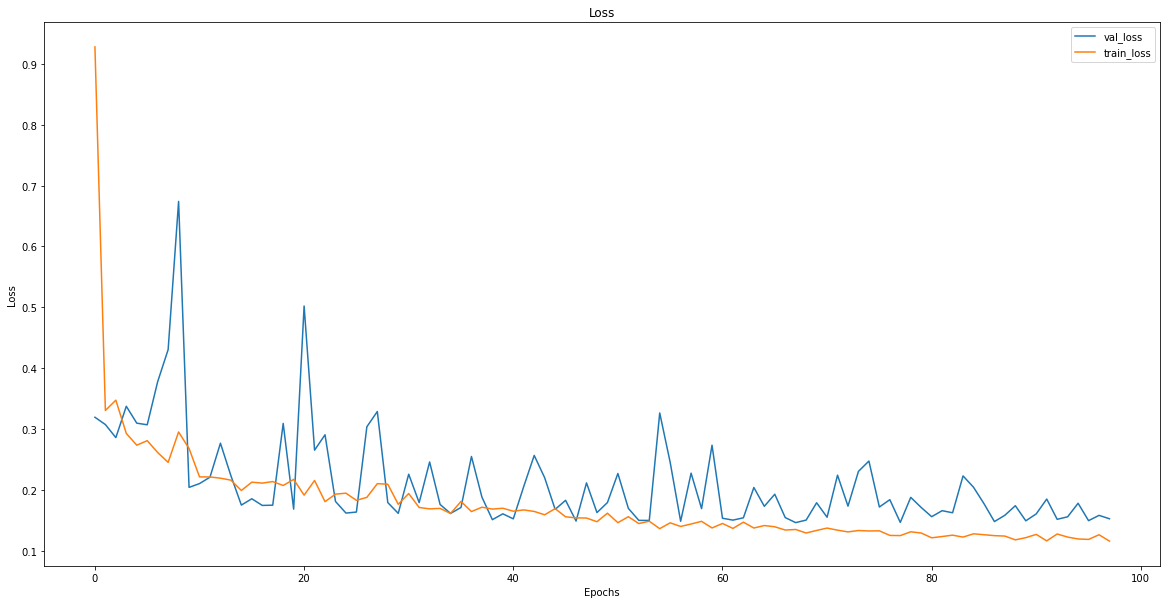

In [386]:
visualize_training_results(results)

In [387]:
preds = model1.predict(X_test)
stuff = pd.DataFrame(preds)
stuff.fillna(stuff.mean(), inplace=True)
preds = np.exp(np.array(stuff))

In [388]:
print("MAE: ",mean_absolute_error(preds, y_exp_test))
print("RMSE:",np.sqrt(mean_squared_error(preds, y_exp_test)))
print("R2:", abs(r2_score(preds, y_exp_test)*100))

MAE:  68811.41453984215
RMSE: 129881.07993638878
R2: 51.1947078172882


# Images

## First Efforts

In [ ]:
df_images

In [ ]:
outputimages = []

In [ ]:
def read_image(location):
    path = str('homeImages/'+location)
    image = cv2.imread(path)
    image = cv2.resize(image, (224, 224))
    return image

In [ ]:
df_images['homeImage'].apply(lambda x: outputimages.append(read_image(x)))

In [ ]:
outputimages = np.array(outputimages)

In [ ]:
outputimages.shape

In [ ]:
outputimages[0].shape

In [ ]:
#reshapes = outputimages.reshape(outputimages.shape[0], -1)
#reshapes.shape

In [ ]:
outputimages = outputimages / 255

In [ ]:
def create_cnn(width, height, depth, filters=(16, 32, 64), regress=False):
    inputShape = (height, width, depth)
    chanDim = -1

    # define the model input
    inputs = Input(shape=inputShape)
    
    # loop over the number of filters
    for (i, f) in enumerate(filters):
        # if this is the first CONV layer then set the input
        # appropriately
        if i == 0:
            x = inputs
        # CONV => RELU => BN => POOL
        x = Conv2D(f, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        
        
    # flatten the volume, then FC => RELU => BN => DROPOUT
    x = Flatten()(x)
    x = Dense(16)(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(0.5)(x)
    
    # apply another FC layer, this one to match the number of nodes
    # coming out of the MLP
    x = Dense(4)(x)
    x = Activation("relu")(x)
    
    # check to see if the regression node should be added
    if regress:
        x = Dense(1, activation="linear")(x)
        
    # construct the CNN
    model = Model(inputs, x)
    
    # return the CNN
    return model

In [ ]:
images_train, images_holdout = train_test_split(outputimages, test_size=0.15, random_state=randomstate, stratify=y_binned)

In [ ]:
# find the largest house price in the training set and use it to
# scale our house prices to the range [0, 1] (will lead to better
# training and convergence)
maxPrice = y_train["price"].max()
trainY = y_train["price"] / maxPrice
testY = y_test["price"] / maxPrice

# create our Convolutional Neural Network and then compile the model
# using mean absolute percentage error as our loss, implying that we
# seek to minimize the absolute percentage difference between our
# price *predictions* and the *actual prices*
model = create_cnn(224, 224, 3, regress=True)
opt = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(loss="mean_absolute_percentage_error", optimizer=opt)

# train the model
print("[INFO] training model...")
model.fit(x=images_train, y=trainY, 
    validation_data=(images_holdout, testY),
    epochs=20, batch_size=8)

In [ ]:
preds = model.predict(images_holdout)

In [ ]:
preds = np.exp(preds)

print("MAE: ",mean_absolute_error(preds, y_exp_test))
print("RMSE:",np.sqrt(mean_squared_error(preds, y_exp_test)))
print("R2:", abs(r2_score(preds, y_exp_test)*100))

## Second Efforts

from: https://rosenfelder.ai/keras-regression-efficient-net/

In [ ]:
df_images['price'] = df['price']

In [ ]:
df_images['location'] = df_images['homeImage'].apply(lambda x: 'homeImages/'+str(x))

In [ ]:
df_images

In [ ]:
images_train, images_holdout = train_test_split(df_images, test_size=0.15, random_state=randomstate, stratify=y_binned)

In [ ]:
def create_generators(train, test, plot_augmentations=False) -> Tuple[Iterator, Iterator]:
    """Accepts two Pandas DataFrames: the training and test DataFrames. 
    Creates and returns
    keras ImageDataGenerators. 
    Within this function you can also visualize the augmentations of the ImageDataGenerators.

    Parameters
    ----------
    train : Your Pandas DataFrame containing your training data.
    test : Your Pandas DataFrame containing your testing data.

    Returns
    -------
    Tuple[Iterator, Iterator]
        keras ImageDataGenerators used for training and testing of your models.
    """
    
    # Section 1 - setting up the image generators
    train_generator = ImageDataGenerator(
        rescale=1.0 / 255,
        rotation_range=5,
        width_shift_range=0.1,
        height_shift_range=0.1,
        brightness_range=(0.75, 1),
        shear_range=0.1,
        zoom_range=[0.75, 1],
        horizontal_flip=True,
        validation_split=0.2,
        )  # create an ImageDataGenerator with multiple image augmentations
    
    # except for rescaling, no augmentations are needed for testing generators
    test_generator = ImageDataGenerator(rescale=1.0 / 255)
    
    # visualize image augmentation sample
    if plot_augmentations == True:
        visualize_augmentations(train_generator, train)

    
    train_generator = train_generator.flow_from_dataframe(
        dataframe=train,
        x_col="location",  # this is where your image data is stored
        y_col="price",  # this is your target feature
        class_mode="raw",  # use "raw" for regressions
        target_size=(224, 224),
        batch_size=128, # increase or decrease to fit your GPU,
        #validate_filenames=False,
        )
  
    test_generator = test_generator.flow_from_dataframe(
        dataframe=test,
        x_col="location",
        y_col="price",
        class_mode="raw",
        target_size=(224, 224),
        batch_size=128,
        #validate_filenames=False,
        )
    
    return train_generator, test_generator

In [ ]:
def visualize_augmentations(data_generator, df):
    """Visualizes the keras augmentations with matplotlib in 3x3 grid. This function is part of create_generators() and
    can be accessed from there.

    Parameters
    ----------
    data_generator : The keras data generator of your training data.
    df : The Pandas DataFrame containing your training data.
    """
    # super hacky way of creating a small dataframe with one image
    series = pd.DataFrame(df.iloc[1]).transpose()

    iterator_visualizations = data_generator.flow_from_dataframe(  # type: ignore
        dataframe=series,
        x_col="location",
        y_col="price",
        class_mode="raw",
        target_size=(224, 224),  # size of the image
        batch_size=1,  # use only one image for visualization
    )

    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)  # create a 3x3 grid
        batch = next(iterator_visualizations)  # get the next image of the generator (always the same image)
        img = batch[0]  # type: ignore
        img = img[0, :, :, :]  # remove one dimension for plotting without issues
        plt.imshow(img)
    plt.show()
    plt.close()

In [ ]:
train_generator, test_generator = create_generators(images_train, images_holdout, plot_augmentations=True)

In [ ]:
def run_model(model_name, model_function, lr, train_generator, validation_generator, test_generator) -> History:  
    """This function runs a keras model with the Ranger optimizer and multiple callbacks. The model is evaluated within
    training through the validation generator and afterwards one final time on the test generator.

    Parameters
    ----------
    model_name : str
        The name of the model as a string.
    model_function : Model
        Keras model function like small_cnn()  or adapt_efficient_net().
    lr : float
        Learning rate.
    train_generator : Iterator
        keras ImageDataGenerators for the training data.
    validation_generator : Iterator
        keras ImageDataGenerators for the validation data.
    test_generator : Iterator
        keras ImageDataGenerators for the test data.

    Returns
    -------
    History
        The history of the keras model as a History object. To access it as a Dict, use history.history. For an example
        see plot_results().
    """

    #callbacks = get_callbacks(model_name)
    # define the callbacks
    callbacks = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, mode='auto')
        
    # Make the model by calling the model function we're using
    model = model_function
     
    # Get the summary steps for the model
    model.summary()
    # save the model steps to a file
    plot_model(model, to_file=model_name + ".jpg", show_shapes=True)

    # different possible optimizers
    radam = tfa.optimizers.RectifiedAdam(learning_rate=lr, decay=1e-3 / 200)
    ranger = tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.5)
    # select the optimizer
    optimizer = radam

    # compule the model
    model.compile(optimizer=optimizer, loss="mean_absolute_error", metrics=[MeanAbsoluteError(), MeanAbsolutePercentageError()])
    
    
    # fit the model
    history = model.fit(
        train_generator,
        epochs=100,
        #shuffle=True, # added this
        #validation_split=.2, # added this
        validation_data=validation_generator,
        callbacks=callbacks,
        workers=6, # adjust this according to the number of CPU cores of your machine
        batch_size=32
    )
    

    model.evaluate(
        test_generator,
        callbacks=callbacks,
    )
    return history  # type: ignore

In [ ]:
def small_cnn() -> Sequential:
    """A very small custom convolutional neural network with image input dimensions of 224x224x3.

    Returns
    -------
    Sequential
        The keras Sequential model.
    """
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(224, 224, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation="relu"))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation="relu"))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation="relu"))
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(512, kernel_initializer='he_normal', activation="relu"))
    model.add(Dense(1, activation='linear'))

    return model

In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

small_cnn_history = run_model(
    model_name="small_cnn",
    model_function=small_cnn(),
    lr=0.01,
    train_generator=train_generator,
    validation_generator=test_generator,
    test_generator=test_generator,
)

In [ ]:
visualize_training_results(small_cnn_history)

In [ ]:
def plot_results(model_history, mean_baseline: float):
    """This function uses seaborn with matplotlib to plot the trainig and validation losses of both input models in an
    sns.relplot(). The mean baseline is plotted as a horizontal red dotted line.

    Parameters
    ----------
    model_history_small_cnn : History
        keras History object of the model.fit() method.
    model_history_eff_net : History
        keras History object of the model.fit() method.
    mean_baseline : float
        Result of the get_mean_baseline() function.
    """

    # create a dictionary for each model history and loss type
    dict1 = {
        "MAPE": model_history.history["mean_absolute_percentage_error"],
        "type": "training",
        "model": "small_cnn",
    }
    dict2 = {
        "MAPE": model_history.history["val_mean_absolute_percentage_error"],
        "type": "validation",
        "model": "small_cnn",
    }


    # convert the dicts to pd.Series and concat them to a pd.DataFrame in the long format
    s1 = pd.DataFrame(dict1)
    s2 = pd.DataFrame(dict2)
    s3 = pd.DataFrame(dict3)
    s4 = pd.DataFrame(dict4)
    df = pd.concat([s1, s2, s3, s4], axis=0).reset_index()
    grid = sns.relplot(data=df, x=df["index"], y="MAPE", hue="model", col="type", kind="line", legend=False)
    grid.set(ylim=(20, 100))  # set the y-axis limit
    for ax in grid.axes.flat:
        ax.axhline(
            y=mean_baseline, color="lightcoral", linestyle="dashed"
        )  # add a mean baseline horizontal bar to each plot
        ax.set(xlabel="Epoch")
    labels = ["small_cnn", "eff_net", "mean_baseline"]  # custom labels for the plot

    plt.legend(labels=labels)
    plt.savefig("training_validation.png")
    plt.show()

In [ ]:
def adapt_efficient_net() -> Model:
    """This code uses adapts the most up-to-date version of EfficientNet with NoisyStudent weights to a regression
    problem. Most of this code is adapted from the official keras documentation.

    Returns
    -------
    Model
        The keras model.
    """
    inputs = Input(
        shape=(224, 224, 3)
    )  # input shapes of the images should always be 224x224x3 with EfficientNetB0
    # use the downloaded and converted newest EfficientNet wheights
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")
    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = BatchNormalization()(x)
    top_dropout_rate = 0.4
    x = Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = Dense(1, name="pred")(x)

    # Compile
    model = Model(inputs, outputs, name="EfficientNet")

    return model

In [ ]:
eff_net_history = run_model(
model_name="eff_net",
model_function=adapt_efficient_net(),
lr=0.5,
train_generator=train_generator,
validation_generator=test_generator,
test_generator=test_generator,
)

plot_results(small_cnn_history, eff_net_history, mean_baseline)

In [ ]:
'''def get_callbacks(model_name):
    """Accepts the model name as a string and returns multiple callbacks for training the keras model.

    Parameters
    ----------
    model_name : str
        The name of the model as a string.

    Returns
    -------
    List[Union[EarlyStopping, ModelCheckpoint]]
        A list of multiple keras callbacks.
    """

    early_stopping_callback = EarlyStopping(
        monitor="val_mean_absolute_percentage_error",
        min_delta=1,  # model should improve by at least 1%
        patience=10,  # amount of epochs  with improvements worse than 1% until the model stops
        verbose=2,
        mode="min",
        restore_best_weights=True,  # restore the best model with the lowest validation error
    )

    #model_checkpoint_callback = ModelCheckpoint(
    #    "./data/models/" + model_name + ".h5",
    #    monitor="val_mean_absolute_percentage_error",
    #    verbose=0,
    #    save_best_only=True,  # save the best model
    #    mode="min",
    #    save_freq="epoch",  # save every epoch
    #)  # saving eff_net takes quite a bit of time
    return [early_stopping_callback]#, model_checkpoint_callback]'''

In [ ]:
break

# Model Selection

In [ ]:
svr = SVR(C=10, epsilon=.05, gamma='auto', kernel='rbf')

svr.fit(X_train, y_train)

In [ ]:
predictions = svr.predict(test)

pred_exp = np.exp(predictions)
actual = np.exp(y_test)

print("MAE: ",int(mean_absolute_error(pred_exp, actual)))
print("RMSE:",int(np.sqrt(mean_squared_error(pred_exp, actual))))
print("R2:", r2_score(pred_exp, actual)*100)

We ran several different types of models, and logged the r^squared and mean absolute error for each model type. Which model performed the best for us?

In [ ]:
# make data frame from our models dictionary
model_types = pd.DataFrame(models)

# sort data frame by mae and reset index
model_types = model_types.sort_values('mae', ascending=True).reset_index()
model_types.drop('index',axis=1, inplace=True)
model_types.set_index('model', inplace=True)

model_types.sort_values('mae', ascending=False)

In [ ]:
# plot model mae

plt.figure(figsize=(15,10))
plt.plot(model_types['mae'])
plt.title("Mean Average Error")
plt.xticks(rotation=90)
plt.xlabel('Model')
plt.ylabel("MAE");

Ultimately we will select the sklearn SVM method for our model. Support Vector Machine's explicit goal to minimize absolute error coordinates nicely with price predictions.

# Realtor Simulator

Realtors have, traditionally, used a more grassroots method for predicting sales prices - the comps model. "Comps" are comparative properties, which are located in a nearby geographical area and have similar feature stats. With comps, a realtor looks for other similar houses in the area of the house being listed, and selects a price appropriately. It's a very literal application of K-nearest neighbors where the 2-dimensional grid is the latitude and longitude, and a neighbor is defined as the points having the closest physical feature similarities. We are going to build a comps "model" and see how our regression model compares. I use "model" in quotes because this isn't a model in machine learning terms. It requires the entire dataset to produce an answer, rather than a regression model which is a mathematical expression that we can save and utilize independently. It is essentially a "realtor simulator" which simulates the behavior of a realtor looking for comps. However for the purposes of our research, this is a Comps Model.

In [ ]:
df.columns

In [ ]:
# our data set for a comps model looks a lot simpler, and requires no feature scaling. Our feature set is smaller.

df_comps = df[['latitude', 'longitude', 'price', 'livingAreaSqFt', 'lotSizeSqFt', 'numOfBedrooms', 'numOfBathrooms', 'avgSchoolRating', 'pr_sqft']]
df_comps

In [ ]:
# our descriptors can help us figure out the appropriate range to use when seeking a comp for each of these features
df_comps.describe()

In [ ]:
# We want both latitude and longitude together in order to locate the exact location of a property.
# We make a new column in our data frame that groups this coordinate location together

dataset = list(zip(df_comps['latitude'],df_comps['longitude']))
df_comps['coordinates'] = dataset
df_comps

There are five functions that we use in our comps finder.

* inclusion_zone returns all properties within a specified lat/long range
* find_comps finds the possible comp properties after getting the properties from inclusion_zone and applying the specifications
* euclidean_distance gets the distance between the target property and the comps properties
* comp_value is the primary function called in the notebook, which calls on get_comps to get the comp properties and then determines if enough comps existed to return a value. If not enough comps were found, it returns none.
* identify_comps returns the actual comp entires that were found for the property

In [ ]:
def inclusion_zone(base_property, housing_set):
    """Function which takes in a property location and returns properties within 
    the predetermined range for latitude and longitude
    ARGUMENTS:
    base_property - property to be priced
    housing_set - housing data to search within for comps"""
    lat = base_property['latitude']
    long = base_property['longitude']
    eligible_zone = housing_set.loc[(housing_set['latitude'] >= (lat-latrange)) & 
                                        (housing_set['latitude'] <= (lat+latrange))&
                                      (housing_set['longitude'] >= (long-longrange)) & 
                                       (housing_set['longitude'] <= (long+longrange))]
    return eligible_zone

def find_comps(base_property, housing_set):
    """Function which takes in a property and its base features. It uses the property to call on the
    inclusion zone function, which finds all properties within a range of latitude and longitude.
    It then refines to the properties in the inclusion zone which match the features within a certain range.
    The function then returns all of the eligible property matches.
    ARGUMENTS:
    base_property - property to be priced
    housing_set - housing data to search within for comps"""
    bedrooms = base_property['numOfBedrooms']
    baths = base_property['numOfBathrooms']
    schools = base_property['avgSchoolRating']
    eligible_zone = inclusion_zone(base_property, housing_set)
    sqft = base_property['livingAreaSqFt']
    lot = base_property['lotSizeSqFt']
    
    eligible_homes = eligible_zone.loc[(eligible_zone['livingAreaSqFt'] >= (sqft*(1-sqftrange))) & 
                                   (eligible_zone['livingAreaSqFt'] <= (sqft*(1+sqftrange))) &
                                  (eligible_zone['lotSizeSqFt'] >= (lot*(1-lotrange))) & 
                                   (eligible_zone['lotSizeSqFt'] <= (lot*(1+lotrange))) &
                                  (eligible_zone['numOfBedrooms'] >= (bedrooms-(1+bedmod))) & 
                                   (eligible_zone['numOfBedrooms'] <= (bedrooms+(1+bedmod))) &
                                       (eligible_zone['numOfBathrooms'] >= (baths - (.5+bathmod))) & 
                                       (eligible_zone['numOfBathrooms'] <= (baths + (.5+bathmod))) &
                                       (eligible_zone['avgSchoolRating'] >= (schools - (.5+schoolmod))) & 
                                       (eligible_zone['avgSchoolRating'] <= (schools + (.5+schoolmod))) 
                                       
                                      ]
    return eligible_homes


# calculate the Euclidean distance between two vectors
def euclidean_distance(row1, row2):
    """calculates the euclidean distance between two coordinates
    ARGUMENTS:
    row1 coordinates of property being priced
    row2 coordinates of comp property"""
    distance = 0.0
    for i in range(len(row1)-1):
        distance += (row1[i] - row2[i])**2
    return sqrt(distance)

def comp_value(base_property, housing_set):
    """Takes in the property to find comps for, and the housing set from which to search for comps.
    Sets up the base feature values based on the property.
    Finds comparable properties by calling the find_comps function and sending the property, housing set and features.
    Checks to ensure there are at least 10 properties in addition to the property being comped. If there are not,
    returns NaN.
    If there are enough properties to perform a comp, it calculates euclidean distance, and uses the 6 closest properties as comps.
    Takes the average price/sqft of the comps and calculates the price for the base property by multiplying its
    sqft_living by the price/sqft for the comps.
    Returns a price if enough comps were located, or None if there were not enough comps.
    ARGUMENTS:
    base_property - property to be priced
    housing_set - housing data to search within for comps
    """
    start_coordinates = base_property['coordinates']
    eligible_homes = find_comps(base_property, housing_set)
    if eligible_homes.shape[0] >= 11:
        eligible_homes['distance'] = eligible_homes['coordinates'].apply(lambda x: euclidean_distance(start_coordinates, x))
        eligible_homes = eligible_homes.sort_values('distance', ascending=True)
        current_index = base_property.name
        comps = eligible_homes.iloc[:6]
        pr_sqft = comps['pr_sqft'].mean()
        comp_value = base_property['livingAreaSqFt'] * pr_sqft
        comp_value = round(comp_value, 0)      
        return comp_value
    else:
        return np.nan

def identify_comps(base_property, housing_set):
    start_coordinates = base_property['coordinates']
    eligible_homes = find_comps(base_property, housing_set)
    if eligible_homes.shape[0] >= 11:
        eligible_homes['distance'] = eligible_homes['coordinates'].apply(lambda x: euclidean_distance(start_coordinates, x))
        eligible_homes = eligible_homes.sort_values('distance', ascending=True)
        current_index = base_property.name
        comps = eligible_homes.iloc[:6]
        return comps
    else:
        return np.nan

In [ ]:
# Create our train/test split on the comps data set
compsfinder, getcomps = train_test_split(df_comps, test_size=0.2, random_state=randomstate)

# reset all of the indices for these data frames just to ward against manipulation mistakes that might result in
# mismatched indices
compsfinder.reset_index(inplace=True)
compsfinder.drop('index', axis=1, inplace=True)

getcomps.reset_index(inplace=True)
getcomps.drop('index', axis=1, inplace=True)

# rename the target price into our test dataset into actual
getcomps.rename(columns={'price':'actual'}, inplace=True)

In [ ]:
'''# set up parameter grid to search

param_grid = {'latrange': [.005, .01], 'longrange': [.005, .01], 'sqftrange': [.025, .05], 'lotrange': [.1, .2], 'bedmod': [.25, .5], 'bathmod': [.25, .5], 'schoolmod': [.5, 1, 2] }

combos = list(ParameterGrid(param_grid))

len(combos)
'''

In [ ]:
'''def kfolds(data, k):
    # Force data as pandas DataFrame
    data = pd.DataFrame(data)
    num_observations = len(data)
    fold_size = num_observations//k
    leftovers = num_observations%k
    folds = []
    start_obs = 0
    for fold_n in range(1,k+1):
        if fold_n <= leftovers:
            #Fold Size will be 1 larger to account for leftovers
            fold =  data.iloc[start_obs : start_obs+fold_size+1] 
            folds.append(fold)
            start_obs +=  fold_size + 1
        else:
            fold =  data.iloc[start_obs : start_obs+fold_size] 
            folds.append(fold)
            start_obs +=  fold_size
            
    return folds 

# Apply kfolds
k=6
test_errs = []
total_scores = {}

comps_folds = kfolds(compsfinder, k)



for i in range(len(combos)):       
    key = str(combos[i])
    total_scores[key] = 0

for n in range(k): 
    
    comps_scores = {}
    fold = comps_folds[n]
    
    for i in range(len(combos)):
        
        key = str(combos[i])
        comps_scores[key] = 0
            
    for i in range(len(combos)):
        parameters = combos[i]
        fold[i] = None
        latrange = .02
        longrange = .02
        sqftrange = .1
        lotrange = .5
        bedmod = 0
        bathmod = 0
        schoolmod = 1
        while fold.isna().sum()[i] != 0:
            fold.loc[fold[i].isna(), i] = fold.loc[fold[i].isna()].apply(lambda x: comp_value(x, compsfinder), axis=1)
            latrange += combos[i]['latrange']
            longrange += combos[i]['longrange']
            sqftrange += combos[i]['sqftrange']
            lotrange += combos[i]['lotrange']
            bedmod += combos[i]['bedmod']
            bathmod += combos[i]['bathmod']
            schoolmod += combos[i]['schoolmod']
        value = round(mean_absolute_error(fold['price'], fold[i]), 2)
        comps_scores[key] += value
        print(i+1, value, parameters)

    for item in comps_scores:
        total_scores[item] += comps_scores[item]

for item in total_scores:
    total_scores[item] = total_scores[item]/k

# picked out the best scoring combination

key_min = min(total_scores.keys(), key=(lambda k: total_scores[k]))
key_max = max(total_scores.keys(), key=(lambda k: total_scores[k]))
print('Best: '+key_min, '\nWorst: '+key_max)
'''

In [ ]:
'''# picked out the best scoring combination

key_min = min(total_scores.keys(), key=(lambda k: total_scores[k]))
key_max = max(total_scores.keys(), key=(lambda k: total_scores[k]))
print('Best: '+key_min, '\nWorst: '+key_max)'''

    Best: {'bathmod': 0.25, 'bedmod': 0.25, 'latrange': 0.005, 'longrange': 0.005, 'lotrange': 0.1, 'schoolmod': 0.5, 'sqftrange': 0.025} 
    Worst: {'bathmod': 0.5, 'bedmod': 0.5, 'latrange': 0.01, 'longrange': 0.01, 'lotrange': 0.2, 'schoolmod': 2, 'sqftrange': 0.05}

In [ ]:
# start with all estimated values empty
getcomps['comps_est'] = np.NaN

latrange = .02
longrange = .02
sqftrange = .1
lotrange = .5
bedmod = 0
bathmod = 0
schoolmod = 1

# call the getcomps function on all rows where no comps have been identified
# this function continues to run so long as any NaN remains
# each time the getcomps function cannot find any comps for a property, the search parameters
# for an acceptable comp are loosened. Eventually all properties will have comps,
# because ultimately the property could use the entire dataset as a comp, if needed.
while getcomps.isna().sum()['comps_est'] != 0:
    getcomps.loc[getcomps.comps_est.isna(), 'comps_est'] = getcomps.loc[getcomps.comps_est.isna()].apply(lambda x: comp_value(x, compsfinder), axis=1)
    latrange += .005
    longrange += .005
    sqftrange += .025
    lotrange += .1
    bedmod += .25
    bathmod += .25
    schoolmod += .5

In [ ]:
# get residuals 
comps_predictions = getcomps[['actual', 'comps_est']]
residuals = getcomps['actual'] - getcomps['comps_est']


# plot residuals
fig = plt.figure(figsize=(20,15))
plt.scatter(getcomps['comps_est'], residuals)

In [ ]:
# Calculate our mean absolute error

mae = round(mean_absolute_error(getcomps['actual'], getcomps['comps_est']), 2)
rmse = round(mean_squared_error(getcomps['actual'], getcomps['comps_est']), 2)

models['Models'].append('Realtor Simulator')
models['r2'].append(None)
models['mae'].append(mae)
models['rmse'].append(rmse)

# Analysis

> Our final model utilizes a combination of continuous variables and one-hot-encoded categoricals to produce a support vector machine regression with R^2 of 79.1%, a mean absolute error of 64k, and a root mean squared error of 105k. I tried several different zip code transformations including polynomial features, mean target encoding, lower-granularity binning, and median rank as a continuous, and ALL of these efforts resulted in a lower R^2 and higher mean absolute error, leading to a final decision to one-hot encode all zip codes individually. Similar efforts on other categoricals such as age and month sold also did not improve the model over one-hot encoding. This resulted in the greatest accuracy despite a model that is more "messy" with a large number of features.

### What are the primary factors influencing housing prices in the Austin metro area?

> Square footage is, unsurprisingly, a key player in house pricing. And as they say, location is everything, and it is the primary influencing factor for a home price in the Austin metro area. Number of bathrooms, school rating, and lot size all contributed a large amount as well.

> These five features alone explain 71% of the price variance.

### Can we effectively use a regression model based system for realtors to determine a proper list price?
> Our model, while explaining about 80% of the price variance with our features, was nonetheless far from accurate in absolute terms. A mean average error of 64k in either direction is a huge variance to a home price - one that is so large that it renders the prediction much less meaningful and useful. Other models need to be explored, better data needs to be sourced, or easy-to-use features that an average realtor is capable of evaluating/acquiring should be added to the model to improve its predictive quality. The model is providing at best a baseline starting point.

### What are the features missing?
> I believe this data set to be missing some key features that have high influence in other housing sets, foremost among them reasonable metrics of home condition, home quality, and neighborhood quality. We attempted to pick up some of the quality and condition metrics via NLP. While the NLP did contribute a significant amount of improvement to the model, it was insufficient to explain all of these missing metrics.


In [ ]:
break

# Visualizations

## Feature Visualizations

In [ ]:
# refresh on our original data frame
df

In [ ]:
# get the columns we are going to make visualizations from
viz_df = df[['price', 'livingAreaSqFt', 'median_zip', 'zip_rank', 'avgSchoolRating']]
viz_df['pr_sf'] = round(viz_df['price']/viz_df['livingAreaSqFt'], 2)
viz_df

In [ ]:
# make simpler variables for our visualiation variables
viz_target = viz_df['price']/100000
viz_sqft = viz_df['livingAreaSqFt']
viz_grade = viz_df['avgSchoolRating']
viz_zip = viz_df['zip_rank'] 
viz_zip2 = viz_df['median_zip']
viz_pr_sf = viz_df['pr_sf']

In [ ]:
# prepare figure
fig, ax = plt.subplots(figsize=(20, 15))

#scatter our data
scatter3 = sns.scatterplot(x=viz_sqft, y="price", data=viz_df, hue='zip_rank', palette='magma_r')
#ax.scatter(viz_sqft, viz_target, c=viz_zip, cmap='magma_r')

# label our axes and title
ax.set_xlabel('Total Square Footage', fontsize=16)
ax.set_ylabel('Price in $100,000', fontsize=16)
ax.set_title("Price per Total Square Footage\nby Zip Code Median Value Rank", fontsize=20);

# save visualization to png
#plt.savefig('images/sqft.png');

In [ ]:
# prepare figure
fig, ax = plt.subplots(figsize=(20, 15))

#scatter our data
scatter3 = sns.scatterplot(x=viz_sqft, y="pr_sf", data=viz_df, hue='zip_rank', palette='magma_r')
#ax.scatter(viz_sqft, viz_target, c=viz_zip, cmap='magma_r')

# label our axes and title
ax.set_xlabel('Total Square Footage', fontsize=16)
ax.set_ylabel('Price per Square Foot', fontsize=16)
ax.set_title("Price per per Square Foot to Total Square Footage\nby Zip Code Median Value Rank", fontsize=20);

# save visualization to png
#plt.savefig('images/pr_sf_zip.png');

In [ ]:
viz_y = viz_df['price']
viz_x = viz_df.drop('price', axis=1)

fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(viz_sqft, viz_grade, viz_target, c=viz_zip, cmap='magma_r')
#ax.scatter(viz_sqft, viz_grade, viz_target, c='red', label="Predictions")
#ax.scatter(viz_sqft, viz_grade, end_z/100000, c='green', label="Actuals")

ax.set_xlabel('Square Feet of Living Space', fontsize=12)
ax.set_ylabel('School Rating', fontsize=12)
ax.set_zlabel('Price', fontsize=12)

ax.set_title("Price per Square Footage and School Rating, by Zip Median Rank", fontsize=20)

# first num is tilt angle, second num is turn angle
# default is about 30,305
# 0, 270 creates side view of pr/sqft
# 0, 360 creates side view of pr/grade
ax.view_init(30, 305)


# save visualization to png
#plt.savefig('images/3d_feats.png');

In [ ]:
break

# APPENDIX

## Tuning With Grid Search

In [ ]:
def get_mlp_model(layerone, layertwo, layerthree, layerfour, layerfive, 
                  learnrate, dropout, dropoutrate, initializer, optimizer,
                  #regularizer, reg_rate, regularizer2, reg_rate2,
                 inputshape=X_train.shape[1],
                 ):
    
    # initialize a sequential model
    model = Sequential()

    
    # add stacks
    model.add(Dense(layerone, activation="relu", kernel_initializer=initializer, kernel_regularizer=l2(.005), input_shape=(inputshape,)))
    
    if dropout: model.add(Dropout(.02))
    
    model.add(Dense(layertwo, kernel_initializer=initializer, kernel_regularizer=l2(.005),activation="relu"))
    
    if dropout: model.add(Dropout(.02))
    
    model.add(Dense(layerthree, kernel_initializer=initializer, activation="relu"))
    
    model.add(Dense(layerfour, kernel_initializer=initializer, activation="relu"))
    
    model.add(Dense(layerfive, kernel_initializer=initializer, activation="relu"))
    
    
    # add an end layer
    model.add(Dense(1, activation="linear"))
    
    # compile the model
    model.compile(optimizer=Adam(learnrate, decay=1e-3 / 200), loss="mean_absolute_error")
    #model.compile(optimizer=optimizer, loss="mean_absolute_error")
    
    # return compiled model
    return model

In [ ]:
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

model = KerasRegressor(build_fn=get_mlp_model, verbose=1)

In [ ]:
# define a grid of the hyperparameter search space
layerone = [128]#, [128, 256, 512]
layertwo = [64]#, 256]
layerthree = [32]#, 128]
layerfour = [16]#, 64]
layerfive = [8]#, 32]
dropout = [True, False]
dropout_rate = [.2]#, .4]
batchSize = [4, 8] #, 16
epochs = [200]
learnrate = [1e-2]#, 1e-3, 1e-4]
initializers = ['he_normal', 'glorot_uniform', 'he_uniform', 'normal']
optimizers = ['Adam(learnrate)', 'SGD(learnrate)', 'RMSprop(learnrate)'] 
regrate1 = [.005]#, 1, 10
regrate2 = [.005]#, 1, 10
regularizers1 = [None, l2(), l1()]
regularizers2 = [None, l2(), l1()]

In [ ]:
# create a dictionary from the hyperparameter grid
grid = dict(
    layerone=layerone,
    layertwo=layertwo,
    layerthree=layerthree,
    layerfour=layerfour,
    layerfive=layerfive,
    dropout=dropout,
    dropoutrate=dropout_rate,
    learnrate=learnrate,
    batch_size=batchSize,
    epochs=epochs,
    initializer=initializers,
    optimizer=optimizers,
    #regularizer=regularizers1,
    #reg_rate=regrate1,
    #regularizer2=regularizers2,
    #reg_rate2=regrate2,
    )

In [ ]:
searcher = RandomizedSearchCV(estimator=model, n_jobs=-1, cv=5,
    param_distributions=grid, scoring="r2")
searchResults = searcher.fit(X_train, y_train)

In [ ]:
# summarize grid search information
bestScore = searchResults.best_score_
bestParams = searchResults.best_params_
print("[INFO] best score is {:.2f} using {}".format(bestScore,
    bestParams))

[INFO] best score is 0.74 using 
{
* 'regularizer2': <keras.regularizers.L1 object at 0x0000023901F34190>, 
* 'regularizer': None, 
* 'reg_rate2': 10, 
* 'reg_rate': 1, 
* 'optimizer': 'Adam(learnrate)', 
* 'learnrate': 0.01, 
* 'layertwo': 64, 
* 'layerthree': 32, 
* 'layerone': 128, 
* 'layerfour': 8, 
* 'layerfive': 4, 
* 'initializer': 'normal', 
* 'epochs': 500, 
* 'dropoutrate': 0, 
* 'dropout': False, 
* 'batch_size': 8
}

In [ ]:
break

## References

https://rosenfelder.ai/keras-regression-efficient-net/#adapt-efficientnetb0-to-our-custom-regression-problem

https://www.pyimagesearch.com/2019/01/28/keras-regression-and-cnns/

https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/

## Nu SVR

In [ ]:
param_grid = {'kernel' : ['linear', 'rbf', 'poly', 'sigmoid'],
              'gamma' : ['scale', 'auto']            
              }

nu_svr = NuSVR()

best_params = grid_optimizer(nu_svr, param_grid, X_train, y_train)

Best mae: -0.132
Best parameters set found on train set: 

{'gamma': 'scale', 'kernel': 'rbf'}

In [ ]:
param_grid = {'nu' : [.25, .5, .75],
              'C' : [1, 10]            
              }

nu_svr = NuSVR(kernel = 'rbf', gamma = 'scale')

best_params = grid_optimizer(nu_svr, param_grid, X_train, y_train)

Best mae: -0.131
Best parameters set found on train set: 

{'C': 1, 'nu': 0.75}

In [ ]:
param_grid = {'nu' : [.75, 1],
              'C' : [1, 3, 5]            
              }

nu_svr = NuSVR(kernel = 'rbf', gamma = 'scale')

best_params = grid_optimizer(nu_svr, param_grid, X_train, y_train)

In [ ]:
nu_svr = NuSVR(kernel = 'rbf', gamma = 'scale', C=1, nu=.75)

## SVM Tuning

In [ ]:
'''# Parameter Tuning

param_grid = {'kernel' : ['linear', 'rbf'],
              'gamma' : ['scale', 'auto'],
              'C':[3,6,10],
              'epsilon':[.05, .1]
              }

svr = SVR(tol=.005, verbose=True)
grid_search = GridSearchCV(svr, param_grid, verbose=10, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

grid_search.fit(X_train_onehot, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))'''

Best parameters set found on train set: 

    {'C': 10, 'epsilon': 0.05, 'gamma': 'auto', 'kernel': 'rbf'}

    Grid scores on train set:

    -0.141 (+/-0.004) for {'C': 3, 'epsilon': 0.05, 'gamma': 'scale', 'kernel': 'linear'}
    -0.144 (+/-0.004) for {'C': 3, 'epsilon': 0.05, 'gamma': 'scale', 'kernel': 'rbf'}
    -0.141 (+/-0.004) for {'C': 3, 'epsilon': 0.05, 'gamma': 'auto', 'kernel': 'linear'}
    -0.139 (+/-0.003) for {'C': 3, 'epsilon': 0.05, 'gamma': 'auto', 'kernel': 'rbf'}
    -0.142 (+/-0.004) for {'C': 3, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
    -0.147 (+/-0.004) for {'C': 3, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
    -0.142 (+/-0.004) for {'C': 3, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'linear'}
    -0.140 (+/-0.002) for {'C': 3, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}
    -0.141 (+/-0.004) for {'C': 6, 'epsilon': 0.05, 'gamma': 'scale', 'kernel': 'linear'}
    -0.149 (+/-0.004) for {'C': 6, 'epsilon': 0.05, 'gamma': 'scale', 'kernel': 'rbf'}
    -0.141 (+/-0.004) for {'C': 6, 'epsilon': 0.05, 'gamma': 'auto', 'kernel': 'linear'}
    -0.136 (+/-0.003) for {'C': 6, 'epsilon': 0.05, 'gamma': 'auto', 'kernel': 'rbf'}
    -0.142 (+/-0.004) for {'C': 6, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
    -0.150 (+/-0.004) for {'C': 6, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
    -0.142 (+/-0.004) for {'C': 6, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'linear'}
    -0.138 (+/-0.002) for {'C': 6, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}
    -0.141 (+/-0.004) for {'C': 10, 'epsilon': 0.05, 'gamma': 'scale', 'kernel': 'linear'}
    -0.151 (+/-0.004) for {'C': 10, 'epsilon': 0.05, 'gamma': 'scale', 'kernel': 'rbf'}
    -0.141 (+/-0.004) for {'C': 10, 'epsilon': 0.05, 'gamma': 'auto', 'kernel': 'linear'}
    -0.135 (+/-0.003) for {'C': 10, 'epsilon': 0.05, 'gamma': 'auto', 'kernel': 'rbf'}
    -0.142 (+/-0.004) for {'C': 10, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
    -0.152 (+/-0.004) for {'C': 10, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
    -0.142 (+/-0.004) for {'C': 10, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'linear'}
    -0.136 (+/-0.002) for {'C': 10, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}

## XGBoost - One Hot Tuning

In [ ]:
# visualize changes to model score as it is tried on different max depths from 10 to 80, to get a starting point for max depth

from sklearn.model_selection import validation_curve
def ValidationCurve(estimator, predictors, target, param_name, hyperparam):
    
    train_score, test_score = validation_curve(estimator, predictors, target, 
                                               param_name, np.arange(1,20,2), 
                                               cv=5, scoring='r2', n_jobs=-4)
    Rsqaured_train = train_score.mean(axis=1)
    Rsquared_test= test_score.mean(axis=1)
    
    plt.figure(figsize=(10,5))
    plt.plot(np.arange(1,20,2), Rsqaured_train, color='r', linestyle='-', marker='o', label='Training Set')
    plt.plot(np.arange(1,20,2), Rsquared_test, color='b', linestyle='-', marker='x', label='Testing Set')
    plt.legend(labels=['Training Set', 'Testing Set'])
    plt.xlabel(hyperparam)
    plt.ylabel('R_squared')
    plt.title("R^squared for Max Depth on Train/Test")
    
ValidationCurve(xgb.XGBRegressor(), x_train_boost, y_train, 'max_depth', 'Maximum Depth')

In [ ]:
# Parameter Tuning max_depth

param_grid = {"max_depth": [4,5,6,]
                          
              }

model = xgb.XGBRegressor(
                 n_estimators=250,                                                                    
                 seed=42,
                 missing=0,
                 eval_metric='mae' )

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-4)
grid_search.fit(x_train_boost, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'max_depth': 4}

    Grid scores on train set:

    0.786 (+/-0.019) for {'max_depth': 4}
    0.785 (+/-0.020) for {'max_depth': 5}
    0.785 (+/-0.021) for {'max_depth': 6}

In [ ]:
# Parameter Tuning learning_rate

param_grid = {"learning_rate" : [.005, .01, .05, .1, .2, .3, .5]  
                          
              }

model = xgb.XGBRegressor(
                 n_estimators=250,
                 max_depth=4,
                 seed=42,
                 missing=0,
                 eval_metric='mae' )

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-4)
grid_search.fit(x_train_boost, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'learning_rate': 0.2}

    Grid scores on train set:

    0.337 (+/-0.030) for {'learning_rate': 0.005}
    0.714 (+/-0.029) for {'learning_rate': 0.01}
    0.793 (+/-0.032) for {'learning_rate': 0.05}
    0.800 (+/-0.029) for {'learning_rate': 0.1}
    0.800 (+/-0.034) for {'learning_rate': 0.2}
    0.792 (+/-0.030) for {'learning_rate': 0.3}
    0.779 (+/-0.037) for {'learning_rate': 0.5}

In [ ]:
# Parameter Tuning max_depth and min_child_weight

param_grid = {"min_child_weight" : [6, 8, 10]            
              }

model = xgb.XGBRegressor(
                 n_estimators=250,
                learning_rate = .2,
                 max_depth=4,
                 seed=42,
                 missing=0,
                 eval_metric='mae' )

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'min_child_weight': 6}

    Grid scores on train set:

    0.805 (+/-0.026) for {'min_child_weight': 6}
    0.804 (+/-0.025) for {'min_child_weight': 8}
    0.805 (+/-0.027) for {'min_child_weight': 10}

In [ ]:
# Parameter Tuning max_depth and min_child_weight

param_grid = {"min_child_weight" : [3, 4, 5, 6, 7]            
              }

model = xgb.XGBRegressor(
                 n_estimators=250,
                learning_rate = .2,
                 max_depth=4,
                 seed=42,
                 missing=0,
                 eval_metric='mae' )

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'min_child_weight': 6}

    Grid scores on train set:

    0.803 (+/-0.034) for {'min_child_weight': 3}
    0.801 (+/-0.030) for {'min_child_weight': 4}
    0.801 (+/-0.029) for {'min_child_weight': 5}
    0.805 (+/-0.026) for {'min_child_weight': 6}
    0.803 (+/-0.025) for {'min_child_weight': 7}

In [ ]:
# Parameter Tuning gamma

param_grid = {'gamma':[.005, .01, .05, .1, .3, .5, 1]            
              }

model = xgb.XGBRegressor(
                n_estimators=250,
                max_depth=4,
                learning_rate = .2,
                min_child_weight=6,
                seed=42,
                missing=0,
                eval_metric='mae' )

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'gamma': 0.005}

    Grid scores on train set:

    0.805 (+/-0.026) for {'gamma': 0.005}
    0.805 (+/-0.026) for {'gamma': 0.01}
    0.805 (+/-0.026) for {'gamma': 0.05}
    0.805 (+/-0.026) for {'gamma': 0.1}
    0.805 (+/-0.026) for {'gamma': 0.3}
    0.805 (+/-0.026) for {'gamma': 0.5}
    0.805 (+/-0.026) for {'gamma': 1}

In [ ]:
# Parameter Tuning subsample

param_grid = {
 'subsample':[.2, .4, .6, .8, 1],
 
    }

model = xgb.XGBRegressor(
                n_estimators=250,
                max_depth=4,
                learning_rate = .2,
                min_child_weight=6,
                gamma=.005,
                seed=42,
                missing=0,
                eval_metric='mae' )

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'subsample': 1}

    Grid scores on train set:

    0.763 (+/-0.037) for {'subsample': 0.2}
    0.778 (+/-0.034) for {'subsample': 0.4}
    0.790 (+/-0.039) for {'subsample': 0.6}
    0.798 (+/-0.024) for {'subsample': 0.8}
    0.805 (+/-0.026) for {'subsample': 1}

In [ ]:
# Parameter Tuning colsample_by_tree

param_grid = {
 'colsample_bytree':[.2, .4, .6, .8, 1]
    }

model = xgb.XGBRegressor(
                n_estimators=250,
                max_depth=4,
                learning_rate = .2,
                min_child_weight=6,
                gamma=.005,
                seed=42,
                missing=0,
                eval_metric='mae' )

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'colsample_bytree': 0.4}

    Grid scores on train set:

    0.794 (+/-0.015) for {'colsample_bytree': 0.2}
    0.806 (+/-0.021) for {'colsample_bytree': 0.4}
    0.800 (+/-0.026) for {'colsample_bytree': 0.6}
    0.798 (+/-0.032) for {'colsample_bytree': 0.8}
    0.805 (+/-0.026) for {'colsample_bytree': 1}

In [ ]:
# Parameter Tuning alpha

param_grid = {
    'reg_alpha':[0.1, 1, 10, 100, 250, 500]
    }

model = xgb.XGBRegressor(
                n_estimators=250,
                max_depth=4,
                learning_rate = .2,
                min_child_weight=6,
                gamma=.005,
                colsample_bytree = .4,
                seed=42,
                missing=0,
                eval_metric='mae' )

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'reg_alpha': 100}

    Grid scores on train set:

    0.806 (+/-0.021) for {'reg_alpha': 0.1}
    0.806 (+/-0.021) for {'reg_alpha': 1}
    0.806 (+/-0.021) for {'reg_alpha': 10}
    0.806 (+/-0.022) for {'reg_alpha': 100}
    0.804 (+/-0.020) for {'reg_alpha': 250}
    0.803 (+/-0.019) for {'reg_alpha': 500}

In [ ]:
# Parameter Tuning alpha

param_grid = {
    'reg_alpha':[50, 75, 100, 125, 150]
    }

model = xgb.XGBRegressor(
                n_estimators=250,
                max_depth=4,
                learning_rate = .2,
                min_child_weight=6,
                gamma=.005,
                colsample_bytree = .4,
                seed=42,
                missing=0,
                eval_metric='mae' )

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'reg_alpha': 75}

    Grid scores on train set:

    0.806 (+/-0.022) for {'reg_alpha': 50}
    0.806 (+/-0.022) for {'reg_alpha': 75}
    0.806 (+/-0.022) for {'reg_alpha': 100}
    0.806 (+/-0.022) for {'reg_alpha': 125}
    0.806 (+/-0.022) for {'reg_alpha': 150}

In [ ]:
# Parameter Tuning lambda

param_grid = {'lambda':[0.1, 1, 10, 100, 500, 1000, 2500]            
              }

model = xgb.XGBRegressor(
                n_estimators=250,
                max_depth=4,
                learning_rate = .2,
                min_child_weight=6,
                gamma=.005,
                colsample_bytree = .4,
                alpha=75,
                seed=42,
                missing=0,
                eval_metric='mae' )

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'lambda': 1}

    Grid scores on train set:

    0.801 (+/-0.022) for {'lambda': 0.1}
    0.806 (+/-0.022) for {'lambda': 1}
    0.803 (+/-0.022) for {'lambda': 10}
    0.801 (+/-0.025) for {'lambda': 100}
    0.791 (+/-0.024) for {'lambda': 500}
    0.787 (+/-0.025) for {'lambda': 1000}
    0.769 (+/-0.023) for {'lambda': 2500}

In [ ]:
# Parameter Tuning num_estimators

param_grid = {'n_estimators':[250, 500, 1000, 5000]            
              }

model = xgb.XGBRegressor(
                n_estimators=250,
                max_depth=4,
                learning_rate = .2,
                min_child_weight=6,
                gamma=.005,
                colsample_bytree = .4,
                alpha=75,
                reg_lambda = 1,
                seed=42,
                missing=0,
                eval_metric='mae') 

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'n_estimators': 500}

    Grid scores on train set:

    0.806 (+/-0.022) for {'n_estimators': 250}
    0.807 (+/-0.022) for {'n_estimators': 500}
    0.804 (+/-0.022) for {'n_estimators': 1000}
    0.799 (+/-0.018) for {'n_estimators': 5000}

## XGBoost - Target Encoded Tuning

In [ ]:
# visualize changes to model score as it is tried on different max depths from 10 to 80, to get a starting point for max depth

from sklearn.model_selection import validation_curve
def ValidationCurve(estimator, predictors, target, param_name, hyperparam):
    
    train_score, test_score = validation_curve(estimator, predictors, target, 
                                               param_name, np.arange(1,20,2), 
                                               cv=5, scoring='r2', n_jobs=-4)
    Rsqaured_train = train_score.mean(axis=1)
    Rsquared_test= test_score.mean(axis=1)
    
    plt.figure(figsize=(10,5))
    plt.plot(np.arange(1,20,2), Rsqaured_train, color='r', linestyle='-', marker='o', label='Training Set')
    plt.plot(np.arange(1,20,2), Rsquared_test, color='b', linestyle='-', marker='x', label='Testing Set')
    plt.legend(labels=['Training Set', 'Testing Set'])
    plt.xlabel(hyperparam)
    plt.ylabel('R_squared')
    plt.title("R^squared for Max Depth on Train/Test")
    
ValidationCurve(xgb.XGBRegressor(), x_train_boost_encoded, y_train, 'max_depth', 'Maximum Depth')

In [ ]:
# Parameter Tuning max_depth

param_grid = {"max_depth": [3,4,5,6,]
                          
              }

model = xgb.XGBRegressor(
                 n_estimators=250,                                                                    
                 seed=42,
                 missing=0,
                 eval_metric='mae' )

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-4)
grid_search.fit(x_train_boost_encoded, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'max_depth': 4}

    Grid scores on train set:

    0.798 (+/-0.037) for {'max_depth': 3}
    0.800 (+/-0.043) for {'max_depth': 4}
    0.792 (+/-0.046) for {'max_depth': 5}
    0.787 (+/-0.038) for {'max_depth': 6}

In [ ]:
# Parameter Tuning learning_rate

param_grid = {"learning_rate" : [.005, .01, .02, .03, .1, .2, .3]            
              }

model = xgb.XGBRegressor(
                 n_estimators=250,
                 max_depth=4,
                 seed=42,
                 missing=0,
                 eval_metric='mae' )

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost_encoded, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'learning_rate': 0.1}

    Grid scores on train set:

    0.342 (+/-0.026) for {'learning_rate': 0.005}
    0.724 (+/-0.027) for {'learning_rate': 0.01}
    0.783 (+/-0.035) for {'learning_rate': 0.02}
    0.792 (+/-0.036) for {'learning_rate': 0.03}
    0.807 (+/-0.035) for {'learning_rate': 0.1}
    0.806 (+/-0.042) for {'learning_rate': 0.2}
    0.800 (+/-0.043) for {'learning_rate': 0.3}

In [ ]:
# Parameter Tuning min_child_weight

param_grid = {"min_child_weight" : [4, 8, 12, 16, 20, 24, 28]            
              }

model = xgb.XGBRegressor(
                 n_estimators=250,
                 max_depth=4,
                learning_rate = .1,
                 seed=42,
                 missing=0,
                 eval_metric='mae' )

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost_encoded, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'min_child_weight': 28}

    Grid scores on train set:

    0.807 (+/-0.037) for {'min_child_weight': 4}
    0.807 (+/-0.030) for {'min_child_weight': 8}
    0.808 (+/-0.031) for {'min_child_weight': 12}
    0.808 (+/-0.029) for {'min_child_weight': 16}
    0.809 (+/-0.028) for {'min_child_weight': 20}
    0.808 (+/-0.028) for {'min_child_weight': 24}
    0.810 (+/-0.032) for {'min_child_weight': 28}

In [ ]:
# Parameter Tuning max_depth and min_child_weight

param_grid = {"min_child_weight" : [28, 32, 36]            
              }

model = xgb.XGBRegressor(
                 n_estimators=250,
                 max_depth=4,
                learning_rate = .1,
                 seed=42,
                 missing=0,
                 eval_metric='mae' )

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost_encoded, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'min_child_weight': 32}

    Grid scores on train set:

    0.810 (+/-0.032) for {'min_child_weight': 28}
    0.811 (+/-0.029) for {'min_child_weight': 32}
    0.811 (+/-0.030) for {'min_child_weight': 36}

In [ ]:
# Parameter Tuning gamma

param_grid = {'gamma':[.01, .05, .1, .3, .5, .7, .9]            
              }

model = xgb.XGBRegressor(
                n_estimators=250,
                max_depth=4,
                learning_rate = .1,
                min_child_weight=32,
                seed=42,
                missing=0,
                eval_metric='mae' )

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost_encoded, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'gamma': 0.01}

    Grid scores on train set:
    
    0.811 (+/-0.029) for {'gamma': 0.01}
    0.811 (+/-0.029) for {'gamma': 0.05}
    0.811 (+/-0.029) for {'gamma': 0.1}
    0.811 (+/-0.029) for {'gamma': 0.3}
    0.811 (+/-0.029) for {'gamma': 0.5}
    0.811 (+/-0.029) for {'gamma': 0.7}
    0.811 (+/-0.029) for {'gamma': 0.9}

In [ ]:
# Parameter Tuning subsample

param_grid = {
 'subsample':[.2, .4, .6, .8, 1],
 
    }

model = xgb.XGBRegressor(
                n_estimators=250,
                max_depth=4,
                learning_rate = .1,
                min_child_weight=32,
                gamma=.01,
                seed=42,
                missing=0,
                eval_metric='mae' )

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost_encoded, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'subsample': 1}

    Grid scores on train set:

    0.792 (+/-0.032) for {'subsample': 0.2}
    0.802 (+/-0.032) for {'subsample': 0.4}
    0.804 (+/-0.033) for {'subsample': 0.6}
    0.808 (+/-0.033) for {'subsample': 0.8}
    0.811 (+/-0.029) for {'subsample': 1}

In [ ]:
# Parameter Tuning colsample_by_tree

param_grid = {
 'colsample_bytree':[.2, .4, .6, .8, 1]
    }

model = xgb.XGBRegressor(
                n_estimators=250,
                max_depth=4,
                learning_rate = .1,
                min_child_weight=32,
                gamma=.01,
                seed=42,
                missing=0,
                eval_metric='mae' )

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost_encoded, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'colsample_bytree': 0.8}

    Grid scores on train set:

    0.807 (+/-0.026) for {'colsample_bytree': 0.2}
    0.809 (+/-0.030) for {'colsample_bytree': 0.4}
    0.810 (+/-0.029) for {'colsample_bytree': 0.6}
    0.811 (+/-0.028) for {'colsample_bytree': 0.8}
    0.811 (+/-0.029) for {'colsample_bytree': 1}

In [ ]:
# Parameter Tuning alpha

param_grid = {
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 10, 100]
    }

model = xgb.XGBRegressor(
                n_estimators=250,
                max_depth=4,
                learning_rate = .1,
                min_child_weight=32,
                gamma=.01,
                colsample_bytree = .8,
                seed=42,
                missing=0,
                eval_metric='mae' )

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost_encoded, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'reg_alpha': 1}

    Grid scores on train set:

    0.811 (+/-0.028) for {'reg_alpha': 1e-05}
    0.811 (+/-0.028) for {'reg_alpha': 0.01}
    0.811 (+/-0.028) for {'reg_alpha': 0.1}
    0.811 (+/-0.028) for {'reg_alpha': 1}
    0.811 (+/-0.028) for {'reg_alpha': 10}
    0.810 (+/-0.028) for {'reg_alpha': 100}

In [ ]:
# Parameter Tuning lambda

param_grid = {'lambda':[0.1, 1, 10, 100, 250, 500, 1000, 2500]            
              }

model = xgb.XGBRegressor(
                n_estimators=250,
                max_depth=4,
                learning_rate = .1,
                min_child_weight=32,
                gamma=.01,
                colsample_bytree = .8,
                alpha=1,
                seed=42,
                missing=0,
                eval_metric='mae' )

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost_encoded, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'lambda': 1}

    Grid scores on train set:

    0.809 (+/-0.028) for {'lambda': 0.1}
    0.811 (+/-0.028) for {'lambda': 1}
    0.808 (+/-0.028) for {'lambda': 10}
    0.803 (+/-0.030) for {'lambda': 100}
    0.800 (+/-0.028) for {'lambda': 250}
    0.793 (+/-0.028) for {'lambda': 500}
    0.784 (+/-0.024) for {'lambda': 1000}
    0.758 (+/-0.020) for {'lambda': 2500}

In [ ]:
# Parameter Tuning num_estimators

param_grid = {'n_estimators':[250, 500, 1000, 5000]            
              }

model = xgb.XGBRegressor(
                n_estimators=250,
                max_depth=4,
                learning_rate = .1,
                min_child_weight=32,
                gamma=.01,
                colsample_bytree = .8,
                alpha=1,
                reg_lambda = 1,
                seed=42,
                missing=0,
                eval_metric='mae') 

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost_encoded, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set:

    {'n_estimators': 500}

    Grid scores on train set:

    0.808 (+/-0.020) for {'n_estimators': 250}
    0.811 (+/-0.022) for {'n_estimators': 500}
    0.810 (+/-0.025) for {'n_estimators': 1000}
    0.803 (+/-0.027) for {'n_estimators': 5000}

# DEPRECATED

## Time Series

In [ ]:
df['latest_saleyear'].unique()
# our data spans all the way from 2019 to 2021.

In [ ]:
df['latest_saledate'].min()
# earliest sale in january 2018

In [ ]:
df['latest_saledate'].max()
# last sale date january 2021

We need to look to some external sources to get house price appreciation info. I went to the Austin Board of Realtors site to get this info from Texas A&M for the Austin metro area that this data covers  
https://www.recenter.tamu.edu/data/housing-activity/#!/activity/MSA/Austin-Round_Rock

* Jan 2018 median: 287000
* Jan 2019 median: 294000 +2.4%
* Jan 2020 median: 305000 +3.7%
* Jan 2021 median: 363830 +19.3% (!!!)

In [ ]:
jan2018_to_2019 = .024/12
jan2019_to_2020 = .037/12
jan2020_to_2021 = .193/12

# create reverse time series number for month
for i in range(1,13):
    df['time_series'] = df['latest_salemonth'].apply(lambda x: abs(x-13))

# adjust 2018 to 2019
df.loc[df['latest_saleyear']==2018, 'adj_price'] = df.loc[df['latest_saleyear']==2018].apply(lambda x: int( (x['price'])*(1+(jan2018_to_2019*x['time_series']))*(1+(jan2019_to_2020*x['time_series']))*(1+(jan2020_to_2021*x['time_series'])) ) , axis=1 )

# adjust 2019 to 2020                                                            
df.loc[df['latest_saleyear']==2019, 'adj_price'] = df.loc[df['latest_saleyear']==2019].apply(lambda x: int( (x['price'])*(1+(jan2019_to_2020*x['time_series']))*(1+(jan2020_to_2021*x['time_series'])) ) , axis=1)
                                                                                  
# adjust 2020 to 2021
df.loc[df['latest_saleyear']==2020, 'adj_price'] = df.loc[df['latest_saleyear']==2020].apply(lambda x: int( (x['price'])*(1+(jan2020_to_2021*x['time_series'])) ), axis=1)

#copy 2021 to self
df.loc[df['latest_saleyear']==2021, 'adj_price'] = df.loc[df['latest_saleyear']==2021].apply(lambda x: int(x['price']), axis=1)

# rename original price column and make adj_price our price column
df.rename(columns={'price' : 'orig_price', 'adj_price' : 'price'}, inplace=True)

# put price at the front of the data frame
df.set_index('price', inplace=True)
df.reset_index(inplace=True)

### Old target encoding

In [ ]:
# Adding target encoding

# get size of training data
num_of_samples = train_data.shape[0]

# determining minimum number of samples for zip and month to use their
# own mean rather than expanding into the full data set mean 
zip_samples = num_of_samples/train_data['zipcode'].unique().shape[0]
month_samples = num_of_samples/train_data['sale_date'].unique().shape[0]

# create smooth additive encoded variables for zipcode, year built, and monthsold
train_data['zip_smooth'] = calc_smooth_mean(train_data, 'zipcode', 'price', zip_samples, train_data)
train_data['year_smooth'] = calc_smooth_mean(train_data, 'yearBuilt', 'price', 300, train_data)
train_data['month_smooth'] = calc_smooth_mean(train_data, 'sale_date', 'price', month_samples, train_data)

# Create a wider lat and long zone to calculate an area mean
train_data['lat_zone'] = round(train_data['latitude'], 2)
train_data['long_zone'] = round(train_data['longitude'], 2)

# determing min number samples for lat and long mean
lat_samples = num_of_samples/train_data['lat_zone'].unique().shape[0]
long_samples = num_of_samples/train_data['long_zone'].unique().shape[0]

# calculate smooth mean variables for lat and long, then create an interactive variable describing both together
train_data['lat_smooth'] = calc_smooth_mean(train_data, 'lat_zone', 'price', lat_samples, train_data)
train_data['long_smooth'] = calc_smooth_mean(train_data, 'long_zone', 'price', long_samples, train_data)
train_data['lat_long'] = (train_data['lat_smooth'] + train_data['long_smooth'])/2

# drop things used for smoothing function
train_data.drop(['lat_zone', 'long_zone', 'latitude', 'longitude'], axis=1, inplace=True)

In [ ]:
# apply target encoding to test data, using train data to map

# create smooth additive encoded variables for zipcode, year built, and monthsold

holdout['month_smooth'] = calc_smooth_mean(train_data, 'latest_salemonth', 'price', month_samples, holdout)
holdout.loc[holdout['month_smooth'].isna(), 'month_smooth'] = train_data['month_smooth'].mean()

# calculate smooth mean variables for lat and long, then create an interactive variable describing both together
holdout['lat_long'] = calc_smooth_mean(train_data, 'lat-long-zone', 'price', lat_long_samples, holdout)
holdout.loc[holdout['lat_long'].isna(), 'lat_long'] = train_data['lat_long'].mean()

##### Study Residuals

In [ ]:
# We need our statsmodels model again to plot residuals
predictors_train = sm.add_constant(X_train_onehot)
model = sm.OLS(y_train, predictors_train).fit()

In [ ]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "livingAreaSqFt", fig=fig)
plt.show()

In [ ]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "avgSchoolRating", fig=fig)
plt.show()

In [ ]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "lotSizeSqFt", fig=fig)
plt.show()

In [ ]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "numOfBedrooms", fig=fig)
plt.show()

## Picking our Base Features

We can use residuals plots to determine if features are important enough to add to our model. If we regress our target on a predictor, and then plot those residuals against a DIFFERENT predictor, our plot will tell us if the new feature might add to our model.

We're planning to one-hot encode our zips, but we'll use our zip_median continuous variable for now to start on.

We're going to add features in order of their correlation with price on our correlation heat map, so our base feature is zip code because it has the strongest correlation.

We regress our target on zip code, then we plot our residuals against total square footage.

In [ ]:
x, y = np.array(df['lat_long']).reshape(-1,1), df['price']
z = np.array(df['livingAreaSqFt']).reshape(-1,1)

model = LinearRegression()
model.fit(x, y)

test_predictions = model.predict(x)

residuals = y - test_predictions

fig = plt.figure(figsize=(15,10))

# Add labels for x and y axes
plt.xlabel('Total Square Footage')
plt.ylabel('Residuals')

# Add a title for the plot
plt.title('Residuals vs Square Footage - Response is Median_Zip')


plt.scatter(z, residuals, label="sample");

In [ ]:
x, y = np.array(df['lat_long']).reshape(-1,1), df['price']
z = np.array(df['avgSchoolRating']).reshape(-1,1)

model = LinearRegression()
model.fit(x, y)

test_predictions = model.predict(x)

residuals = y - test_predictions

fig = plt.figure(figsize=(15,10))

# Add labels for x and y axes
plt.xlabel('Average School Rating')
plt.ylabel('Residuals')

# Add a title for the plot
plt.title('Residuals vs Average School Rating - Response is Median Zip Code')


plt.scatter(z, residuals, label="sample");

Regression on median zip, this time residuals plotted against school rating. This may not have the strong relationship we expected.

In [ ]:
x, y = np.array(df['lat_long']).reshape(-1,1), df['price']
z = np.array(df['lotSizeSqFt']).reshape(-1,1)

model = LinearRegression()
model.fit(x, y)

test_predictions = model.predict(x)

residuals = y - test_predictions

fig = plt.figure(figsize=(15,10))

# Add labels for x and y axes
plt.xlabel('Lot Size Square Feet')
plt.ylabel('Residuals')

# Add a title for the plot
plt.title('Residuals vs Lot Size Square Feet - Response is Median_Zip')

plt.scatter(z, residuals, label="sample");

Interesting how past a certain lot size, larger rounded numbers are used instead of specific numbers. There does seem to be a relationship here.

In [ ]:
x, y = np.array(df['lat_long']).reshape(-1,1), df['price']
z = np.array(df['numOfBedrooms']).reshape(-1,1)

model = LinearRegression()
model.fit(x, y)

test_predictions = model.predict(x)

residuals = y - test_predictions

fig = plt.figure(figsize=(15,10))

# Add labels for x and y axes
plt.xlabel('Number of Bedrooms')
plt.ylabel('Residuals')

# Add a title for the plot
plt.title('Residuals vs Number of Bedrooms - Response is Median_Zip')

plt.scatter(z, residuals, label="sample");

If we can see a pattern when we plot residuals vs a different predictor, it can tell us if a feature might add value to our model.

# TEMP

# Visualizing our Data

In [ ]:
# redo our zip code medians and rankings after outlier removal

# apply the median home price per zip code to the data frame again after outlier removal
df['median_zip'] = df['zipcode'].apply(lambda x: round(df.loc[df['zipcode']==x]['price'].median(), 0))

# group our dataframe by zipcode on median home price, sorted ascending. We want to bin like-medians together.
zipsorted = pd.DataFrame(df.groupby('zipcode')['price'].median().sort_values(ascending=True))

# divide our dataframe into groups with entries per group as specified above,
# and assign this number to a new column
zipsorted['rank'] = np.divmod(np.arange(len(zipsorted)), 1)[0]+1

# make a new column on our dataframe. Look up each zip entry's group, and append to the column.
df['zip_rank'] = df['zipcode'].apply(lambda x: make_group(x, zipsorted, 'rank'))

In [ ]:
# re-visualize zip code as a color function, using the median zip after outlier removal. 

fig, ax = plt.subplots(figsize=(20, 15))

ax.scatter(df['median_zip'], df['price'] /100000, c=df['zip_rank'], cmap='magma_r')

ax.set_xlabel('Zip Code by Median Rank', fontsize=12)
ax.set_ylabel('Price in $100,000', fontsize=12)
ax.set_title('Price per Zip Code Median, by Zip Code Median Home Value', fontsize=20);

# save visualization to png
#plt.savefig('images/zip_prices.png')

In [ ]:
# apply the median price per square foot per zip code to the data frame
df['pr_sqft'] = df.apply(lambda x: round( (x['price'] / x['livingAreaSqFt'] ), 0), axis=1 )

In [ ]:
fig, ax = plt.subplots(figsize=(20, 15))

ax.scatter(df['livingAreaSqFt'], df['pr_sqft'], c=df['zip_rank'], cmap='magma_r')

ax.set_xlabel('Total Square Footage', fontsize=12)
ax.set_ylabel('Price Per Square Foot', fontsize=12)
ax.set_title('Price Per Square Foot to Total Square Footage, by Zip Code Median Rank', fontsize=20);

# save visualization to png
#plt.savefig('images/zip_prices.png')

In [ ]:
#dropping irrationally high pr/sqft
df.drop(df[df['pr_sqft']>1000].index, inplace=True)

In [ ]:
# visualize zip code as a color function, on a plot of price per square footage

fig, ax = plt.subplots(figsize=(20, 15))

ax.scatter(df['livingAreaSqFt'], df['price'] /100000, c=df['zip_rank'], cmap='magma_r')

ax.set_xlabel('Square Feet of Living Space', fontsize=12)
ax.set_ylabel('Price in $100,000', fontsize=12)
ax.set_title('Price per Total Square Footage, by Zip Code Median Rank', fontsize=20)
;

In [ ]:
low_zips = df.loc[df['median_zip']<df['price'].mean()]
high_zips = df.loc[df['median_zip']>=df['price'].mean()]

In [ ]:
# visualize zip code as a color function, on a plot of price per square footage

fig, ax = plt.subplots(figsize=(20, 15))

ax.scatter(low_zips['livingAreaSqFt'], low_zips['price'] /100000, c=low_zips['zip_rank'], cmap='magma_r')

ax.set_xlabel('Square Feet of Living Space', fontsize=12)
ax.set_ylabel('Price in $100,000', fontsize=12)
ax.set_title('Price per Total Square Footage, by Zip Code Median Rank \nFor Zip Medians under Mean', fontsize=20)
;

In [ ]:
# visualize zip code as a color function, on a plot of price per square footage

fig, ax = plt.subplots(figsize=(20, 15))

ax.scatter(high_zips['livingAreaSqFt'], high_zips['price'] /100000, c=high_zips['zip_rank'], cmap='magma_r')

ax.set_xlabel('Square Feet of Living Space', fontsize=12)
ax.set_ylabel('Price in $100,000', fontsize=12)
ax.set_title('Price per Total Square Footage, by Zip Code Median Rank\nFor Zip Medians over Mean', fontsize=20)
;

Here's a fun way to see the improvements to our data quality after we clean outliers! A much deeper color map.

In [ ]:
# plotting latitude and longitude as a visual scatter plot. The improved color map actually visually demonstrates
# the removal of extreme price outliers.

plt.figure(figsize=(25,25))

sns.scatterplot(data=df, x="longitude", y="latitude", hue="price", palette="magma_r");

In [ ]:
# we can also map our zip codes in this way.

plt.figure(figsize=(25,25))

sns.scatterplot(data=df, x="longitude", y="latitude", hue="zip_rank", palette="magma_r");

## Study Target Variable

In [ ]:
#histogram and normal probability plot
sns.distplot(df['price'], fit=norm);
fig = plt.figure()

res = stats.probplot(df['price'], plot=plt)

# our sales price histogram is positively skewed and has a high peak
# Our QQ-plot shows that we have heavy tails with right skew

In [ ]:
#skewness and kurtosis
print("Skewness: %f" % df['price'].skew())
print("Kurtosis: %f" % df['price'].kurt())

# price is highly right skewed
# very positive kurtosis, indicating lots in the tails. We can see those tails in the right skew.

In [ ]:
# log transform our target price to improve normality of distribution
df_target_log = np.log(df['price'])

#histogram and normal probability plot
sns.distplot(df_target_log, fit=norm);
fig = plt.figure()
res = stats.probplot(df_target_log, plot=plt)

# Our target price is more normally distributed when log transformed, so we'll be doing that when we make our model


We are TEMPORARILY doing target encoding on the ENTIRE data set. We will be overwriting these encodings later in order to avoid data leakage! We're doing it now for EDA purposes ONLY.

In [ ]:
df = target_encoding(df, df)

## Correlations/Multicollinearity

In [ ]:
# look for multicollinearity of features
fig, ax = plt.subplots(figsize=(20, 20))

sns.heatmap(df.corr(), center=0,  
           vmin=-1, vmax=1,  square=True)

# title
plt.title('PEARSON CORRELATION MATRIX', fontsize=18)

plt.show()

In [ ]:
df.corr()

In [ ]:
#Get our list of highly correlated feature pairs with following steps:

# save correlation matrix as a new data frame
# converts all values to absolute value
# stacks the row:column pairs into a multindex
# reset the index to set the multindex to seperate columns
# sort values. 0 is the column automatically generated by the stacking
df_correlations = df.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns in a new column named "pairs"
df_correlations['pairs'] = list(zip(df_correlations.level_0, df_correlations.level_1))

# set index to pairs
df_correlations.set_index(['pairs'], inplace = True)

# rename our results column to correlation
df_correlations.rename(columns={0: "correlation"}, inplace=True)

# Drop 1:1 correlations to get rid of self pairs
df_correlations.drop(df_correlations[df_correlations['correlation'] == 1.000000].index, inplace=True)

# view pairs above 75% correlation and below 90% correlation (engineered features will correlate with each other above 95%)
df_correlations[(df_correlations.correlation>.75) & (df_correlations.correlation<.95)]


In [ ]:
# Check out our variables correlationg with price
df_correlations = df.corr().abs().stack().reset_index().sort_values(0, ascending=False)
df_correlations.loc[df_correlations['level_0'] == 'price'].sort_values(0, ascending=False)

We'll use:

* Keep garageSpaces (highest correlation with Price) and drop parkingSpaces, hasGarage, numOfParkingFeatures
* Keep numOfHighSchools and drop numOfPrimarySchools, numOfSchools, numOfElementarySchools, numOfMiddleSchools
* Keep zip_smooth and drop median_zip, zip_rank
* Keep lat_long and drop lat_smooth, long_smooth
* numOfBathrooms correlates with square footage, but I'm not dropping either


In [ ]:
df

We can get a sense of the most important features to our price from our correlation table. Zipcode as a plain variable does not correlate, which makes sense, because without some sort of transformation it is an arbitrary unordered number. We can see how as a smooth target encoding, it becomes the MOST important contributor to price. We can see here that big contributors to price include

    * zip code in a target encoded form
    * Lat/long in a target encoded form
    * livingAreaSqFt
    * numBathrooms
    * avgSchoolRating
    * lotSizeSqFt

## Looking for Polynomials

In [ ]:
# Checking out our mean sales price for year built scattered versus price shows a polynomial relationship

yearly_prices = df.groupby('yearBuilt')['price'].mean()

plt.scatter(yearly_prices.index, yearly_prices)
plt.title("Linearity check")
plt.xlabel('year built')
plt.ylabel('sales price')
plt.show()

Looks somewhat polynomial

In [ ]:
# Checking out our mean sales price for square footage  scattered versus price shows a polynomial relationship
lat_prices = df.groupby('livingAreaSqFt')['price'].mean()

plt.scatter(lat_prices.index, lat_prices)
plt.title("Linearity check")
plt.xlabel('lat')
plt.ylabel('sales price')
plt.show()

This looks linear

In [ ]:
# Checking out our mean sales price for lot size scattered versus price shows a polynomial relationship
lat_prices = df.groupby('lotSizeSqFt')['price'].mean()

plt.scatter(lat_prices.index, lat_prices)
plt.title("Linearity check")
plt.xlabel('lat')
plt.ylabel('sales price')
plt.show()

This looks somewhat linear

In [ ]:
# Checking out our mean sales price for average school size, scattered versus price shows a polynomial relationship
lat_prices = df.groupby('avgSchoolSize')['price'].mean()

plt.scatter(lat_prices.index, lat_prices)
plt.title("Linearity check")
plt.xlabel('lat')
plt.ylabel('sales price')
plt.show()

This looks meaningless

In [ ]:
#df.to_csv('listings_cleaned_austin.csv', index=False)

## Categoricals

In [ ]:
categoricals = ['price', 'zipcode', 'homeType', 'sale_date', 'numOfHighSchools', 'propertyTaxRate']

df_categoricals = df[categoricals]

# plot our categoricals as box plots vs price
def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)
    
f = pd.melt(df_categoricals, id_vars=['price'], value_vars=categoricals)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(boxplot, "value", "price")

## Continuous

In [ ]:
small_cont = ['garageSpaces', 'hasAssociation', 'hasCooling', 'hasHeating', 'hasSpa',
       'hasView', 'numPriceChanges','numOfAccessibilityFeatures', 'numOfAppliances',
       'numOfPatioAndPorchFeatures', 'numOfSecurityFeatures',
       'numOfWaterfrontFeatures', 'numOfWindowFeatures',
       'numOfCommunityFeatures', 'avgSchoolRating', 
       'numOfBathrooms', 'numOfBedrooms', 'numOfStories']
# plot our continuous as box plots vs price
def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)

f = pd.melt(df, id_vars=['price'], value_vars=small_cont)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(boxplot, "value", "price")


In [ ]:
column = ['numOfPhotos', 'lotSizeSqFt', 'livingAreaSqFt',
     'avgSchoolDistance', 'avgSchoolRating', 'avgSchoolSize',
             'lat_long', 'month_smooth', 'zip_smooth', 'year_smooth', 'yearBuilt']

# check linearity of continuous predictors

fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(15,25), sharey=True)

for ax, column in zip(axes.flatten(), column):
    ax.scatter(df[column], df['price']/100000, label=column, alpha=.1)
    ax.set_title(f'Sale Price vs {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Sale Price in $100,000')

fig.tight_layout()

Positive relationship observed with:
* lot size
* square footage
* school rating
* number of bedrooms
* lat/long

Negative relationship observed with:
* number of price changes

Others seem neutral/uncertain